# Data Mining Project - Phase 1
_Authors: Tooraj Taraz - Afarin Zamanian_

## Introduction
In the previous phase of this project, we extracted offered courses from the [UvA website](studiegids.uva.nl). The raw results were then stored in a csv file, categorised by departments offering the course.

The collected columns are:
* university: the name of the university (_Universiteit van Amsterdam_)
* abbreviation: the abbreviation of the university name (_UVA_)
* department: the name of the department offering the course, there are over 20 different departments, some offering as few as 11 courses (_Amsterdam College of Law_) and some over 480 (_Graduate School of Humanities_).
* course title
* unit: the number of units (credits) the course is worth
* objective: the objective of the course
* prerequisites: the prerequisites of the course (optional)
* references: the references of the course (optional)
* scores: methods of scoring the course (optional)
* description: brief description of the course 
* university homepage
* course homepage

In this phase, we will use preprocessing techniques to clean the data, then use Apriori algorithm to find the most common itemsets appearing in course details of various departments, followed by application of association rules to find the association rules that are most likely to be true for each department.


## Preprocessing

For this step, we will use NLP tools to clean the relevant texts. The libraries used include [`nltk`](https://www.nltk.org) with wordnet (for lemmatizing and ommitting stop words), `re` (for regex), and [`KeyBert`](https://github.com/MaartenGr/KeyBERT) (for extracting keywords per entry).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# nlp tools
import nltk
import re

In [5]:
uva = pd.read_csv("data/UvA.csv")

We first merge the text columns we are interested in into one, discarding common data such as university name, and keeping course title, credits, and department name to be used in the next step. The merged columns are description, objective, prerequisites, and references.

In [4]:
# merge columns description, prerequisite, references, and objectives into one column called merged_desc
uva['Description'] = uva['Description'].fillna('')
uva['Prerequisite'] = uva['Prerequisite'].fillna('')
uva['Objective'] = uva['Objective'].fillna('')
uva['References'] = uva['References'].fillna('')
uva['merged_desc'] = uva['Description'] + ' ' + uva['Prerequisite'] + ' ' + uva['Objective'] + ' ' + uva['References']

In [10]:
uva

University Abbreviation  Department  \
0     Universiteit van Amsterdam          UvA         AUC   
1     Universiteit van Amsterdam          UvA         AUC   
2     Universiteit van Amsterdam          UvA         AUC   
3     Universiteit van Amsterdam          UvA         AUC   
4     Universiteit van Amsterdam          UvA         AUC   
...                          ...          ...         ...   
3224  Universiteit van Amsterdam          UvA  Psychology   
3225  Universiteit van Amsterdam          UvA  Psychology   
3226  Universiteit van Amsterdam          UvA  Psychology   
3227  Universiteit van Amsterdam          UvA  Psychology   
3228  Universiteit van Amsterdam          UvA  Psychology   

                                           Course title   Unit  \
0     A Golden Age? History and Heritage of the Dutc...   6 EC   
1                               Academic Writing Skills   6 EC   
2                                    Adaptation Studies   6 EC   
3                                             Addiction   6 EC   
4                             Advanced Creative Writing   6 EC   
...                                                 ...    ...   
3224  Theory Development in Social and Organisationa...   6 EC   
3225                          Tutorials Academic Skills   0 EC   
3226  Work and Organisational Psychology & Social Ps...  12 EC   
3227                        Work, Motivation and Health   9 EC   
3228  Youth Interventions: Theory, Research and Prac...   6 EC   

                                              Professor  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
3224  dr. AC Homan (co-ordinator)\nProf.dr. G.A. van...   
3225  A. Boering MSc (co-ordinator)\nC.J. Hulleman M...   
3226                   drs. R.A. Voskens (co-ordinator)   
3227                      dr. B.G. Adams (co-ordinator)   
3228                    dr. T.J. Dekkers (co-ordinator)   

                                              Objective  \
0     The students will learn about historical devel...   
1     Students will:\n\n• demonstrate digital litera...   
2     Students will be able to understand and analyz...   
3     • The student understands basic pharmacologica...   
4     1) The student builds off her/his prior knowle...   
...                                                 ...   
3224  After this course, students will be able to (a...   
3225  After participating in the Academic Skills tut...   
3226  After completing this course students will be ...   
3227  After this course, all students will be able t...   
3228  At the end of the course, students can (a) nam...   

                                           Prerequisite  Required Skills  \
0                                                                    NaN   
1                                                                    NaN   
2     All of the following:\n60 EC\nIntroduction to ...              NaN   
3     One of the following:\nBrain and Cognition\nMe...              NaN   
4     Creative Writing\nRegistration\nThis course is...              NaN   
...                                                 ...              ...   
3224                                                                 NaN   
3225                                                                 NaN   
3226  Introductory course in psychology, basic knowl...              NaN   
3227                                                                 NaN   
3228                                                                 NaN   

      Outcome                                         References  \
0         NaN  Reader with articles or Textbook (check Canvas)\n   
1         NaN  • Reading Sele

This is the dataframe without the unnecessary columns.

Now we will use `nltk` along with wordnet model to lemmatise the text through a function called `clean_text`. There is also an option to use the stemmer which is not recommended, as it makes the resulting text nearly incomprehensible.

In [5]:
import string
nltk.download('wordnet')
def clean_text(text, stopwords=None, flem=False, fstem=True):
  text = re.sub(r'[^\w\s\d]', '', str(text).lower().strip())
  text = "".join([char.lower() for char in text if char not in string.punctuation]) 
  lst_text = text.split()
  if stopwords is not None:
    lst_text = [word for word in lst_text if word not in 
                stopwords]
  if fstem == True:
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]
  if flem == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
  text = " ".join(lst_text)
  return text

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/toorajtaraz/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We can take a look at the stopwords that will be ommitted in the next step.

In [6]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
print(stopwords[:20])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/toorajtaraz/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/toorajtaraz/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

And an example of the cleaned text vs the original merged entry:

In [9]:
uva["merged_clean"] = uva["merged_desc"].apply(lambda x: 
          clean_text(x, flem=True, fstem=False, 
          stopwords=stopwords))
uva[['merged_desc', 'merged_clean']].head()

merged_desc  \
0  The so called Golden Age, which corresponds ro...   
1  Academic Writing Skills is an introduction to ...   
2  Although the originality of a work of literatu...   
3  The goal of this course is to gain insight int...   
4  This course continues the diverse exploration ...   

                                        merged_clean  
0  called golden age corresponds roughly 17th cen...  
1  academic writing skill introduction academic s...  
2  although originality work literature art often...  
3  goal course gain insight etiology neurobiology...  
4  course continues diverse exploration creative ...

A more complete version of the above table is provided below:

In [26]:
pd.set_option("display.max_colwidth", -1)
uva[['merged_desc', 'merged_clean']].head(5)

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


merged_desc  \
0  The so called Golden Age, which corresponds roughly with the 17th century, was an extremely important period in Dutch history. The enormous increase in trading activity at that time not only increased social mobility but produced a wealthy merchant class. This merchant class was important for patronage of the arts, literature and science and the merchants were also in a position to influence urban planning and architecture of that time. Topics to be covered in the course include colonialism and trade; scientific discoveries; navigation; the Dutch East India Company and the Amsterdam Bank; tulip fever; the perceived tradition of religious tolerance in the Netherlands; still-life painting; the Dutch political scene and the Dutch Republic in the century Europe. Students will learn about historical developments in the Dutch Republic that made the 17th century such an important period for The Netherlands, the ‘Golden Age’, and will trace the significance of these developments to the present day.\n  The students will learn about historical developments in the history of the Low Countries that led to the founding of the Dutch Republic. \nThey will acquire a general knowledge of the main developments in this crucial period of the country in a wide range of topics, such as political thinking, art and literature. \nThey will be able to recognize, identify and analyze specific elements of Dutch 17th century culture. \nThey will be able to describe the influences and significance of the Golden Age for today’s society and be able to understand and to critically relate to the meaning of the Golden Age for the Dutch national identity.\n Reader with articles or Textbook (check Canvas)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1  Academic Writing Skills is an introduction to academic study and the foundation skills required for becoming a successful junior member of an interdisciplinary academic community. The syllabus reflects a progression of competence in the primary skills of academic reading, research, writing and presentation while fostering both cross-disciplinary and digital literacy. Activities will combine a range of digital and print media and will draw on the six AUC themes, emphasizing interdisciplinarity and diversity, demonstrating contemporary

In [27]:
# resetting dataframe visualization options
pd.set_option("display.max_colwidth", 50)

### Extracting Keywords
Using KeyBERT with its `all-MiniLM-L6-v2` model, we can extract the keywords from the text. It also has the option to provide stopwords, which we won't be using since we have already stripped the stopwords. The other parameter we will be using is the n-gram range, which we set to (1,1) initially (finding single words).

In [11]:
from keybert import KeyBERT
kw_model = KeyBERT(model='all-MiniLM-L6-v2')
doc = "goal course gain insight etiology neurobiology addictive behaviour course explores various topic study drug addiction primary emphasis psychological biological theory drug addiction genetic personality trait representing risk factor development addiction identified important topic clinical diagnosis treatment psychomotor stimulant eg amphetamine cocaine opiate eg heroin morphine drug also socially accepted drug nicotine alcohol figure prominently examination pharmacological property addictive drug much course relates important moodelevating effect drug biological action however nondrug related addiction gambling obsessive eating also discussed also address huge impact addiction society effectiveness drug policy one following brain cognition medicinal chemistry brain mind registration course open auc student student understands basic pharmacological principle explain drug action student able understand different drug abuse exert acute action brain student knowledge diagnostic criterion current theory addiction student able explain contribution genetic environmental personality factor development persistence addictive behavior student able understand neurobiological mechanism may explain persistent character addiction student gain insight huge impact addiction society student learns current treatment option available drug addict student understands pro con current drug policy able defend debate student conduct literature search able collect summarize interpret information finding conclusion reported oral presentation written essay psychopharmacology drug brain behavior 2005 meyer quenzer sinauer associate inc literature bb"
keywords = kw_model.extract_keywords(doc, highlight=True, keyphrase_ngram_range=(1, 1), stop_words=None)

goal course gain insight etiology neurobiology addictive behaviour course explores various 
topic study drug addiction primary emphasis psychological biological theory drug addiction 
genetic personality trait representing risk factor development addiction identified important
topic clinical diagnosis treatment psychomotor stimulant eg amphetamine cocaine opiate eg 
heroin morphine drug also socially accepted drug nicotine alcohol figure prominently 
examination pharmacological property addictive drug much course relates important 
moodelevating effect drug biological action however nondrug related addiction gambling 
obsessive eating also discussed also address huge impact addiction society effectiveness drug
policy one following brain cognition medicinal chemistry brain mind registration course open 
auc student student understands basic pharmacological principle explain drug action student 
able understand different drug abuse exert acute action brain student knowledge diagnostic 
criterion current theory addiction student able explain contribution genetic environmental 
personality factor development persistence addictive behavior student able understand 
neurobiological mechanism may explain persistent character addiction student gain insight 
huge impact addiction society student learns current treatment option available drug addict 
student understands pro con current drug policy able defend debate student conduct literature
search able collect summarize interpret information finding conclusion reported oral 
presentation written essay psychopharmacology drug brain behavior 2005 meyer quenzer sinauer 
associate inc literature bb

As seen above, the keywords extracted for the course _Addiction_ are quite related to the subject of the course. The separation of 'addicttion' from 'addictive', 'addict', etc is due to lack of stemming in the cleaning step, but as mentioned before the stemming tool makes many words nearly incomprehensible to the human analyst.

The function also provides a similarity index:

In [39]:
print(keywords)

[('addiction', 0.4446), ('addict', 0.4035), ('opiate', 0.3736), ('addictive', 0.3609), ('amphetamine', 0.3547)]


Below are more examples of running the KeyBERT model on the cleaned texts of the first five courses, showing remarkable results:

In [40]:
uva['keywords'] = uva['merged_clean'][:5].apply(lambda x:
            kw_model.extract_keywords(x, highlight=True, keyphrase_ngram_range=(1, 1), stop_words=None))
uva.head()

called golden age corresponds roughly 17th century extremely important period dutch history 
enormous increase trading activity time increased social mobility produced wealthy merchant 
class merchant class important patronage art literature science merchant also position 
influence urban planning architecture time topic covered course include colonialism trade 
scientific discovery navigation dutch east india company amsterdam bank tulip fever perceived
tradition religious tolerance netherlands stilllife painting dutch political scene dutch 
republic century europe student learn historical development dutch republic made 17th century
important period netherlands golden age trace significance development present day student 
learn historical development history low country led founding dutch republic acquire general 
knowledge main development crucial period country wide range topic political thinking art 
literature able recognize identify analyze specific element dutch 17th century culture able 
describe influence significance golden age today society able understand critically relate 
meaning golden age dutch national identity reader article textbook check canvas

academic writing skill introduction academic study foundation skill required becoming 
successful junior member interdisciplinary academic community syllabus reflects progression 
competence primary skill academic reading research writing presentation fostering 
crossdisciplinary digital literacy activity combine range digital print medium draw six auc 
theme emphasizing interdisciplinarity diversity demonstrating contemporary relevance global 
perspective reflecting student interest course accommodate different learning method style 
section syllabus involve theoretical practical dimension encouraging reflection enabling 
student learn registration course open auc student student demonstrate digital literacy 
academic context learn read engage text range disciplinary perspective develop writing 
argumentation skill appropriate different discipline learn recognize apply different research
methodology learn recognize practice different genre mode academic discourse develop 
vocabulary appropriate academic environment improve analytic critical thinking skill work 
independently part collaborative group learn review critique work peer improve listening 
comprehension develop presentation skill participate discussion workshop debate reading 
selection canvas selection h ramsey fowler jane e aaron little brown handbook pearson longman
13th edition auc writing centre web resource purdue owl uva digital library

although originality work literature art often privileged main criterion evaluation writer 
playwright filmmaker artist always looked previous work inspiration adaptation word always 
played leading role within literature culture primary mode creative transfer production 
arguably globalization advancing technology made making process adaptation increasingly 
complex increasing scope mode reception interaction across culture genre platform class 
examines theory practice adaptation consider adaptation cultural product primarily using case
study literature film also including theatre art medium etc cultural process existing work 
adapted another medium form another context culture attempt interdisciplinary global 
perspective drawing experience interest group introductory part course explore possible 
framework analyzing adaptation student introduced main issue debate involved adaptation study
b primary tool proposed study adaptation throughout course attempt move beyond idea 
adaptation source text represent singular one directional line influence past present ii kind
comparative review focus good original bad adaptation interrogate dialogue multiple version 
narrative pretext ie case study adaptation modify source particular way story adapted 
particular aesthetic commercial technical social political demand particular mode eg film 
novel game suited others purpose adaptation move across different culture genre time period 
case study adaptation point departure consider different approach theorization adaptation 
examine various relevant notion originality fidelity authenticity universality history canon 
genre throughout course student asked bring example adaptation discus class following 60 ec 
introduction literary cultural theory registration course open auc student student able 
understand analyze dynamic play concerning theory practice adaptation familiar terminology 
theory study adaptation able consider adaptation within broader cultural context student 
improve analytical skill ability work research project individually collaboratively finally 
student develop interdisciplinary international approach engaging different field study local
global perspective main source jane austen pride prejudice lewis carroll alices adventure 
wonderland ahmed saadawi frankenstein baghdad john luther long madame butterfly andrea dunbar
arbor selected academic essayschapters several film

goal course gain insight etiology neurobiology addictive behaviour course explores various 
topic study drug addiction primary emphasis psychological biological theory drug addiction 
genetic personality trait representing risk factor development addiction identified important
topic clinical diagnosis treatment psychomotor stimulant eg amphetamine cocaine opiate eg 
heroin morphine drug also socially accepted drug nicotine alcohol figure prominently 
examination pharmacological property addictive drug much course relates important 
moodelevating effect drug biological action however nondrug related addiction gambling 
obsessive eating also discussed also address huge impact addiction society effectiveness drug
policy one following brain cognition medicinal chemistry brain mind registration course open 
auc student student understands basic pharmacological principle explain drug action student 
able understand different drug abuse exert acute action brain student knowledge diagnostic 
criterion current theory addiction student able explain contribution genetic environmental 
personality factor development persistence addictive behavior student able understand 
neurobiological mechanism may explain persistent character addiction student gain insight 
huge impact addiction society student learns current treatment option available drug addict 
student understands pro con current drug policy able defend debate student conduct literature
search able collect summarize interpret information finding conclusion reported oral 
presentation written essay psychopharmacology drug brain behavior 2005 meyer quenzer sinauer 
associate inc literature bb

course continues diverse exploration creative writing discipline art form student immerse 
theory practice writing creatively creative writing registration course open auc student 1 
student build herhis prior knowledge creative writing 2 student illustrates knowledge herhis 
individual voice personal aesthetic writing discussion 3 student learns work larger creative 
project 4 student learns role research come working creative project 5 student immersed 
practice writing hopefully continue write class end textbook versal issue 12

University Abbreviation Department  \
0  Universiteit van Amsterdam          UvA        AUC   
1  Universiteit van Amsterdam          UvA        AUC   
2  Universiteit van Amsterdam          UvA        AUC   
3  Universiteit van Amsterdam          UvA        AUC   
4  Universiteit van Amsterdam          UvA        AUC   

                                        Course title  Unit Professor  \
0  A Golden Age? History and Heritage of the Dutc...  6 EC       NaN   
1                            Academic Writing Skills  6 EC       NaN   
2                                 Adaptation Studies  6 EC       NaN   
3                                          Addiction  6 EC       NaN   
4                          Advanced Creative Writing  6 EC       NaN   

                                           Objective  \
0  The students will learn about historical devel...   
1  Students will:\n\n• demonstrate digital litera...   
2  Students will be able to understand and analyz...   
3  • The student understands basic pharmacologica...   
4  1) The student builds off her/his prior knowle...   

                                        Prerequisite  Required Skills  \
0                                                                 NaN   
1                                                                 NaN   
2  All of the following:\n60 EC\nIntroduction to ...              NaN   
3  One of the following:\nBrain and Cognition\nMe...              NaN   
4  Creative Writing\nRegistration\nThis course is...              NaN   

   Outcome                                         References  \
0      NaN  Reader with articles or Textbook (check Canvas)\n   
1      NaN  • Reading Selections on Canvas\n\n• Selections...   
2      NaN  Main sources:\nJane Austen, Pride and Prejudic...   
3      NaN  • Psychopharmacology, drugs, the brain, and be...   
4      NaN                      Textbook: Versal (Issue 12)\n   

                                              Scores  \
0  Exams, participation, presentation, paper (see...   
1  • Annotated Bibliography (15%)\n• Research Con...   
2  #1 – Essay #1 (20%) – Week 6\n\n#2 – Group Tea...   
3  Midterm exam (20%)\nFinal exam (20%)\nStudent ...   
4  Writing Project: 25%\nPresentation: 25%\nPortf...   

                                         Description  Projects  \
0  The so called Golden Age, which corresponds ro...       NaN   
1  Academic Writing Skills is an introduction to ...       NaN   
2  Although the originality of a work of literatu...       NaN   
3  The goal of this course is to gain insight int...       NaN   
4  This course continues the diverse exploration ...       NaN   

         University Homepage  \
0  https://studiegids.uva.nl   
1  https://studiegids.uva.nl   
2  https://studiegids.uva.nl   
3  https://studiegids.uva.nl   
4  https://studiegids.uva.nl   

                                     Course Homepage Professor Homepage  \
0  https://studiegids.uva.nl/xmlpages/page/2021-2...                NaN   
1  https://studiegids.uva.nl/xmlpages/page/2021-2...                NaN   
2  https://studiegids.uva.nl/xmlpages/page/2021-2...                NaN   
3  https://studiegids.uva.nl/xmlpages/page/2021-2...                NaN   
4  https://studiegids.uva.nl/xmlpages/page/2021-2...                NaN   

                                         merged_desc  \
0  The so called Golden Age, which corresponds ro...   
1  Academic Writing Skills is an introduction to ...   
2  Although the originality of a work of literatu...   
3  The goal of this course is to gain insight int...   
4  This course continues the diverse exploration ...   

                                        merged_clean  \
0  called golden age corresponds roughly 17th cen...   
1  academic writing skill introduction academic s...   
2  although originality work literature art often...   
3  goal course gain insight etiology neurobiology...   
4  course continues diverse exploration creative ...   

                        

In the next step, we do this for all the entries, but with various n-gram ranges from 1 to 3.

In [13]:
for i in range(1, 4):
    for j in range(1, 4):
        #not passing stop words because we've already removed them
        uva[f'keywords_{i}_{j}'] = uva['merged_clean'].apply(lambda x:
                    kw_model.extract_keywords(x, highlight=False, keyphrase_ngram_range=(i, j), stop_words=None))
uva.head()

University Abbreviation Department  \
0  Universiteit van Amsterdam          UvA        AUC   
1  Universiteit van Amsterdam          UvA        AUC   
2  Universiteit van Amsterdam          UvA        AUC   
3  Universiteit van Amsterdam          UvA        AUC   
4  Universiteit van Amsterdam          UvA        AUC   

                                        Course title  Unit Professor  \
0  A Golden Age? History and Heritage of the Dutc...  6 EC       NaN   
1                            Academic Writing Skills  6 EC       NaN   
2                                 Adaptation Studies  6 EC       NaN   
3                                          Addiction  6 EC       NaN   
4                          Advanced Creative Writing  6 EC       NaN   

                                           Objective  \
0  The students will learn about historical devel...   
1  Students will:\n\n• demonstrate digital litera...   
2  Students will be able to understand and analyz...   
3  • The student understands basic pharmacologica...   
4  1) The student builds off her/his prior knowle...   

                                        Prerequisite  Required Skills  \
0                                                                 NaN   
1                                                                 NaN   
2  All of the following:\n60 EC\nIntroduction to ...              NaN   
3  One of the following:\nBrain and Cognition\nMe...              NaN   
4  Creative Writing\nRegistration\nThis course is...              NaN   

   Outcome  ...                                       merged_clean  \
0      NaN  ...  called golden age corresponds roughly 17th cen...   
1      NaN  ...  academic writing skill introduction academic s...   
2      NaN  ...  although originality work literature art often...   
3      NaN  ...  goal course gain insight etiology neurobiology...   
4      NaN  ...  course continues diverse exploration creative ...   

                                        keywords_1_1  \
0  [(colonialism, 0.3153), (literature, 0.304), (...   
1  [(literacy, 0.4732), (academic, 0.4421), (stud...   
2  [(literature, 0.3591), (cultural, 0.3162), (ad...   
3  [(addiction, 0.4446), (addict, 0.4035), (opiat...   
4  [(writing, 0.4873), (write, 0.4306), (student,...   

                                        keywords_1_2  \
0  [(dutch history, 0.4774), (17th century, 0.473...   
1  [(literacy academic, 0.5888), (skill academic,...   
2  [(study adaptation, 0.5093), (adaptation stude...   
3  [(addiction student, 0.5854), (drug addiction,...   
4  [(writing student, 0.6252), (practice writing,...   

                                        keywords_1_3 keywords_2_1  \
0  [(17th century important, 0.537), (netherlands...           []   
1  [(skill academic reading, 0.6083), (literacy a...           []   
2  [(consider adaptation cultural, 0.5469), (stud...           []   
3  [(study drug addiction, 0.6908), (addiction st...           []   
4  [(creative writing student, 0.7125), (writing ...           []   

                                        keywords_2_2  \
0  [(dutch history, 0.4774), (17th century, 0.473...   
1  [(literacy academic, 0.5888), (skill academic,...   
2  [(study adaptation, 0.5093), (adaptation stude...   
3  [(addiction student, 0.5854), (drug addiction,...   
4  [(writing student, 0.6252), (practice writing,...   

                                        keywords_2_3 keywords_3_1  \
0  [(17th century important, 0.537), (netherlands...           []   
1  [(skill academic reading, 0.6083), (literacy a...           []   
2  [(consider adaptation cultural, 0.5469), (stud...           []   
3  [(study drug addiction, 0.6908), (addiction st...           []   
4  [(creative writing student, 0.7125), (writing ...           []   

  keywords_3_2                                       keywords_3_3  
0           []  [(17th century important, 0.537), (netherlands...  
1           []  [(skill academic reading, 0.6083), (academic w...  
2

As observed, the best range is still (1,1) since the data is quite discrete and it picks up combinations that are only related due to lack of whitespace, stopwords, punctuations, and HTML tags (e.g. picking up _'addiction student'_ as a 2-gram keyword).

In [14]:
# save uva into data/uva_keywords_{datetime}.csv
now = pd.datetime.now()
uva.to_csv(f"data/uva_keywords_{now}.csv", index=False)

In [2]:
# load the saved dataframe
uva = pd.read_csv("data/uva_keywords_2022-06-04-16-57-48_266864.csv")

## Course Statistics

To get a better idea of how we expect the future esteps to work and to know our data better, we will use various statistics per department.

In [27]:
# extracting statistics from the dataframe
deps = {}
for dep in uva['Department']:
    if dep not in deps:
        deps[dep] = {}
        deps[dep]["course_count"] = 1
    else:
        deps[dep]["course_count"] += 1

deps

{'AUC': {'course_count': 268},
 'Amsterdam College of Law': {'course_count': 10},
 'Amsterdam Graduate Law School': {'course_count': 106},
 'College of Child Development and Education': {'course_count': 22},
 'College of Communication': {'course_count': 47},
 'College of Economics and Business': {'course_count': 154},
 'College of Humanities': {'course_count': 413},
 'College of Informatics': {'course_count': 14},
 'College of Life Sciences': {'course_count': 26},
 'College of Sciences': {'course_count': 64},
 'College of Social Sciences': {'course_count': 207},
 'Graduate School of Business': {'course_count': 144},
 'Graduate School of Child Development and Education': {'course_count': 24},
 'Graduate School of Communication': {'course_count': 62},
 'Graduate School of Economics': {'course_count': 85},
 'Graduate School of Humanities': {'course_count': 438},
 'Graduate School of Informatics': {'course_count': 124},
 'Graduate School of Life and Earth Sciences': {'course_count': 115},


In [56]:
def convert_to_float(x, debug=False):
    try:
        x = float(x)
        if debug:
            print(f"Converted {x} to float")
    except Exception as e:
        if debug:
            print(f"Failed to convert {x} to float because {e}")
        x = 0
    return x

def clean_up_unit(x, debug=False):
    if debug:
        print(f"Cleaning up {x}")
    try:
        x = x.replace(" EC", "")
        x = x.replace(",", ".")
        if debug:
            print(f"Removed EC from {x} and replaced commas with dots")
    except Exception as e:
        if debug:
            print(f"Failed to remove EC from {x} because {e}")
    
    return x


In [59]:
# clean up Units by removing EC from them and storing them as floats
uva['Unit'] = uva['Unit'].apply(lambda x: clean_up_unit(x, False))
uva['Unit'] = uva['Unit'].apply(lambda x: convert_to_float(x, False))
uva.head()

University Abbreviation Department  \
0  Universiteit van Amsterdam          UvA        AUC   
1  Universiteit van Amsterdam          UvA        AUC   
2  Universiteit van Amsterdam          UvA        AUC   
3  Universiteit van Amsterdam          UvA        AUC   
4  Universiteit van Amsterdam          UvA        AUC   

                                        Course title  Unit Professor  \
0  A Golden Age? History and Heritage of the Dutc...   6.0       NaN   
1                            Academic Writing Skills   6.0       NaN   
2                                 Adaptation Studies   6.0       NaN   
3                                          Addiction   6.0       NaN   
4                          Advanced Creative Writing   6.0       NaN   

                                           Objective  \
0  The students will learn about historical devel...   
1  Students will:\n\n• demonstrate digital litera...   
2  Students will be able to understand and analyz...   
3  • The student understands basic pharmacologica...   
4  1) The student builds off her/his prior knowle...   

                                        Prerequisite  Required Skills  \
0                                                NaN              NaN   
1                                                NaN              NaN   
2  All of the following:\n60 EC\nIntroduction to ...              NaN   
3  One of the following:\nBrain and Cognition\nMe...              NaN   
4  Creative Writing\nRegistration\nThis course is...              NaN   

   Outcome  ...                                       merged_clean  \
0      NaN  ...  called golden age corresponds roughly 17th cen...   
1      NaN  ...  academic writing skill introduction academic s...   
2      NaN  ...  although originality work literature art often...   
3      NaN  ...  goal course gain insight etiology neurobiology...   
4      NaN  ...  course continues diverse exploration creative ...   

                                        keywords_1_1  \
0  [('colonialism', 0.3153), ('literature', 0.304...   
1  [('literacy', 0.4732), ('academic', 0.4421), (...   
2  [('literature', 0.3591), ('cultural', 0.3162),...   
3  [('addiction', 0.4446), ('addict', 0.4035), ('...   
4  [('writing', 0.4873), ('write', 0.4306), ('stu...   

                                        keywords_1_2  \
0  [('dutch history', 0.4774), ('17th century', 0...   
1  [('literacy academic', 0.5888), ('skill academ...   
2  [('study adaptation', 0.5093), ('adaptation st...   
3  [('addiction student', 0.5854), ('drug addicti...   
4  [('writing student', 0.6252), ('practice writi...   

                                        keywords_1_3 keywords_2_1  \
0  [('17th century important', 0.537), ('netherla...           []   
1  [('skill academic reading', 0.6083), ('literac...           []   
2  [('consider adaptation cultural', 0.5469), ('s...           []   
3  [('study drug addiction', 0.6908), ('addiction...           []   
4  [('creative writing student', 0.7125), ('writi...           []   

                                        keywords_2_2  \
0  [('dutch history', 0.4774), ('17th century', 0...   
1  [('literacy academic', 0.5888), ('skill academ...   
2  [('study adaptation', 0.5093), ('adaptation st...   
3  [('addiction student', 0.5854), ('drug addicti...   
4  [('writing student', 0.6252), ('practice writi...   

                                        keywords_2_3 keywords_3_1  \
0  [('17th century important', 0.537), ('netherla...           []   
1  [('skill academic reading', 0.6083), ('literac...           []   
2  [('consider adaptation cultural', 0.5469), ('s...           []   
3  [('study drug addiction', 0.6908), ('addiction...           []   
4  [('creative writing student', 0.7125), ('writi...           []   

  keywords_3_2                                       keywords_3_3  
0           []  [('17th century important', 0.537), ('netherla...  
1           []  [('skill academic reading', 0.6083), ('academi...  
2

In [62]:
# Calculate the sum and the average and the min and max and median of the Unit column for non-nan values
grouped_by_dep = uva.groupby('Department')['Unit'].agg(['sum', 'mean', 'min', 'max', 'median'])

for dep in deps:
    deps[dep]['sum'] = grouped_by_dep.loc[dep]['sum']
    deps[dep]['mean'] = grouped_by_dep.loc[dep]['mean']
    deps[dep]['min'] = grouped_by_dep.loc[dep]['min']
    deps[dep]['max'] = grouped_by_dep.loc[dep]['max']
    deps[dep]['median'] = grouped_by_dep.loc[dep]['median']


In [ ]:
# save deps into data/stats_{datetime}.csv
now = pd.datetime.now()
pd.DataFrame.from_dict(deps, orient='index').to_csv(f"data/stats_{now}.csv", index=True)

In [3]:
stats = pd.read_csv('data/stats_2022-06-04 17-56-37_481212.csv')

Below graphs shows course count by department:

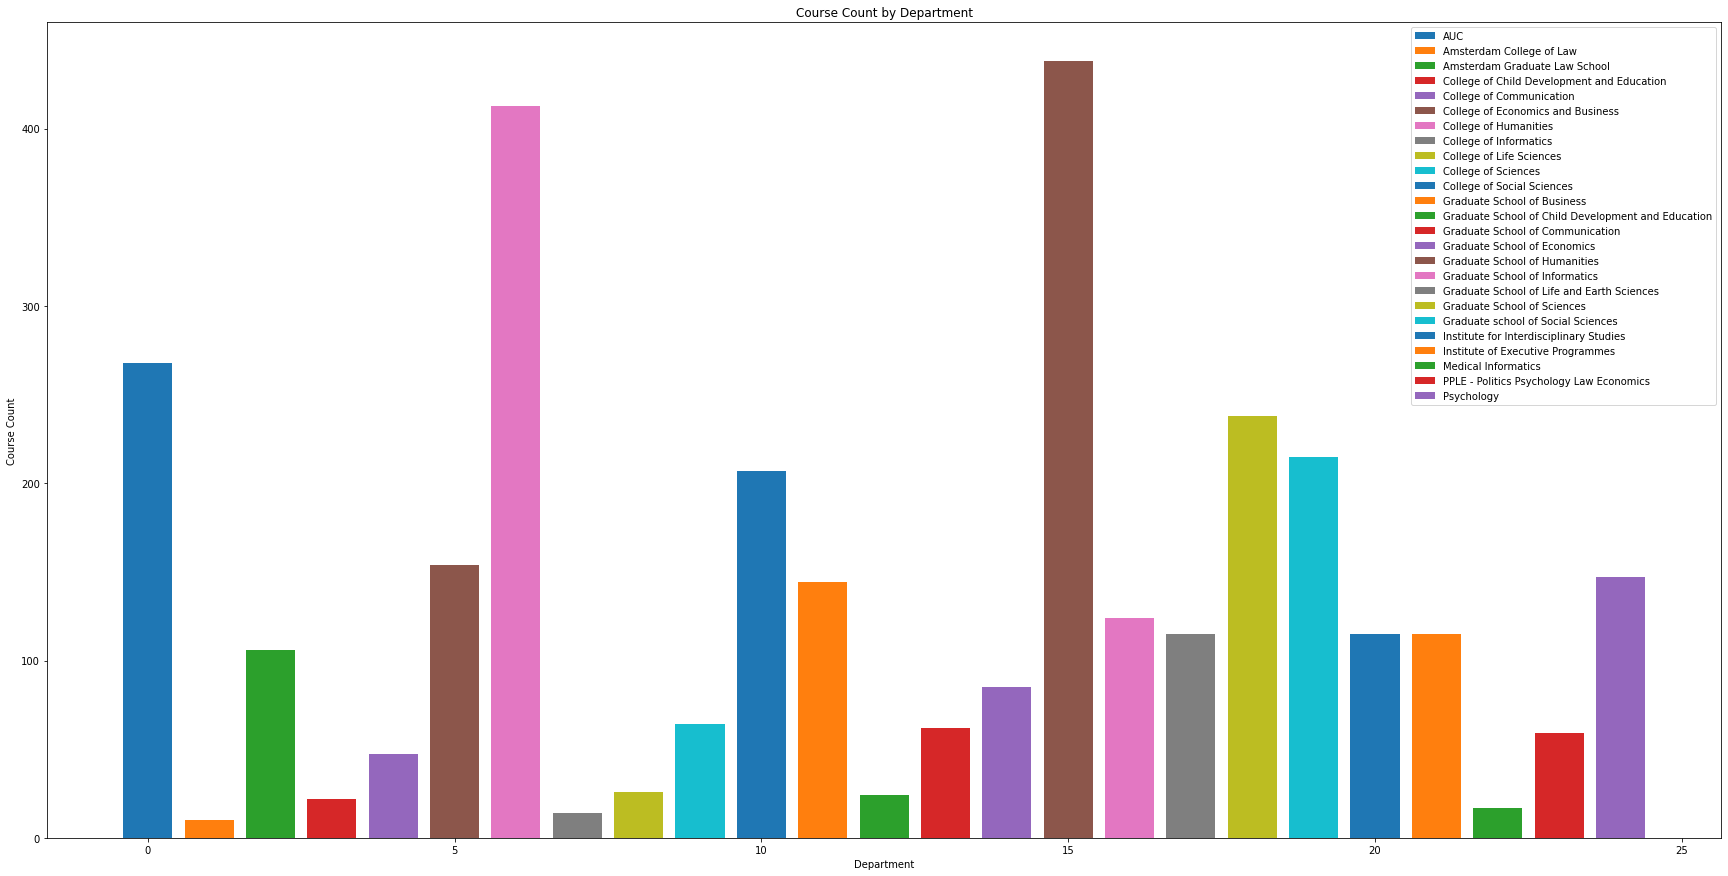

In [27]:
from matplotlib import pyplot as plt

#Plotting the stats
#plot cource_count for each department in a bar chart with different colors
plt.figure(figsize=(30,15))
for index, row in stats.iterrows():
    plt.bar(index, row['course_count'], label=row[0])
    plt.legend()
plt.xlabel("Department")
plt.ylabel("Course Count")
plt.title("Course Count by Department")
plt.show()



And the course credit mean per department:

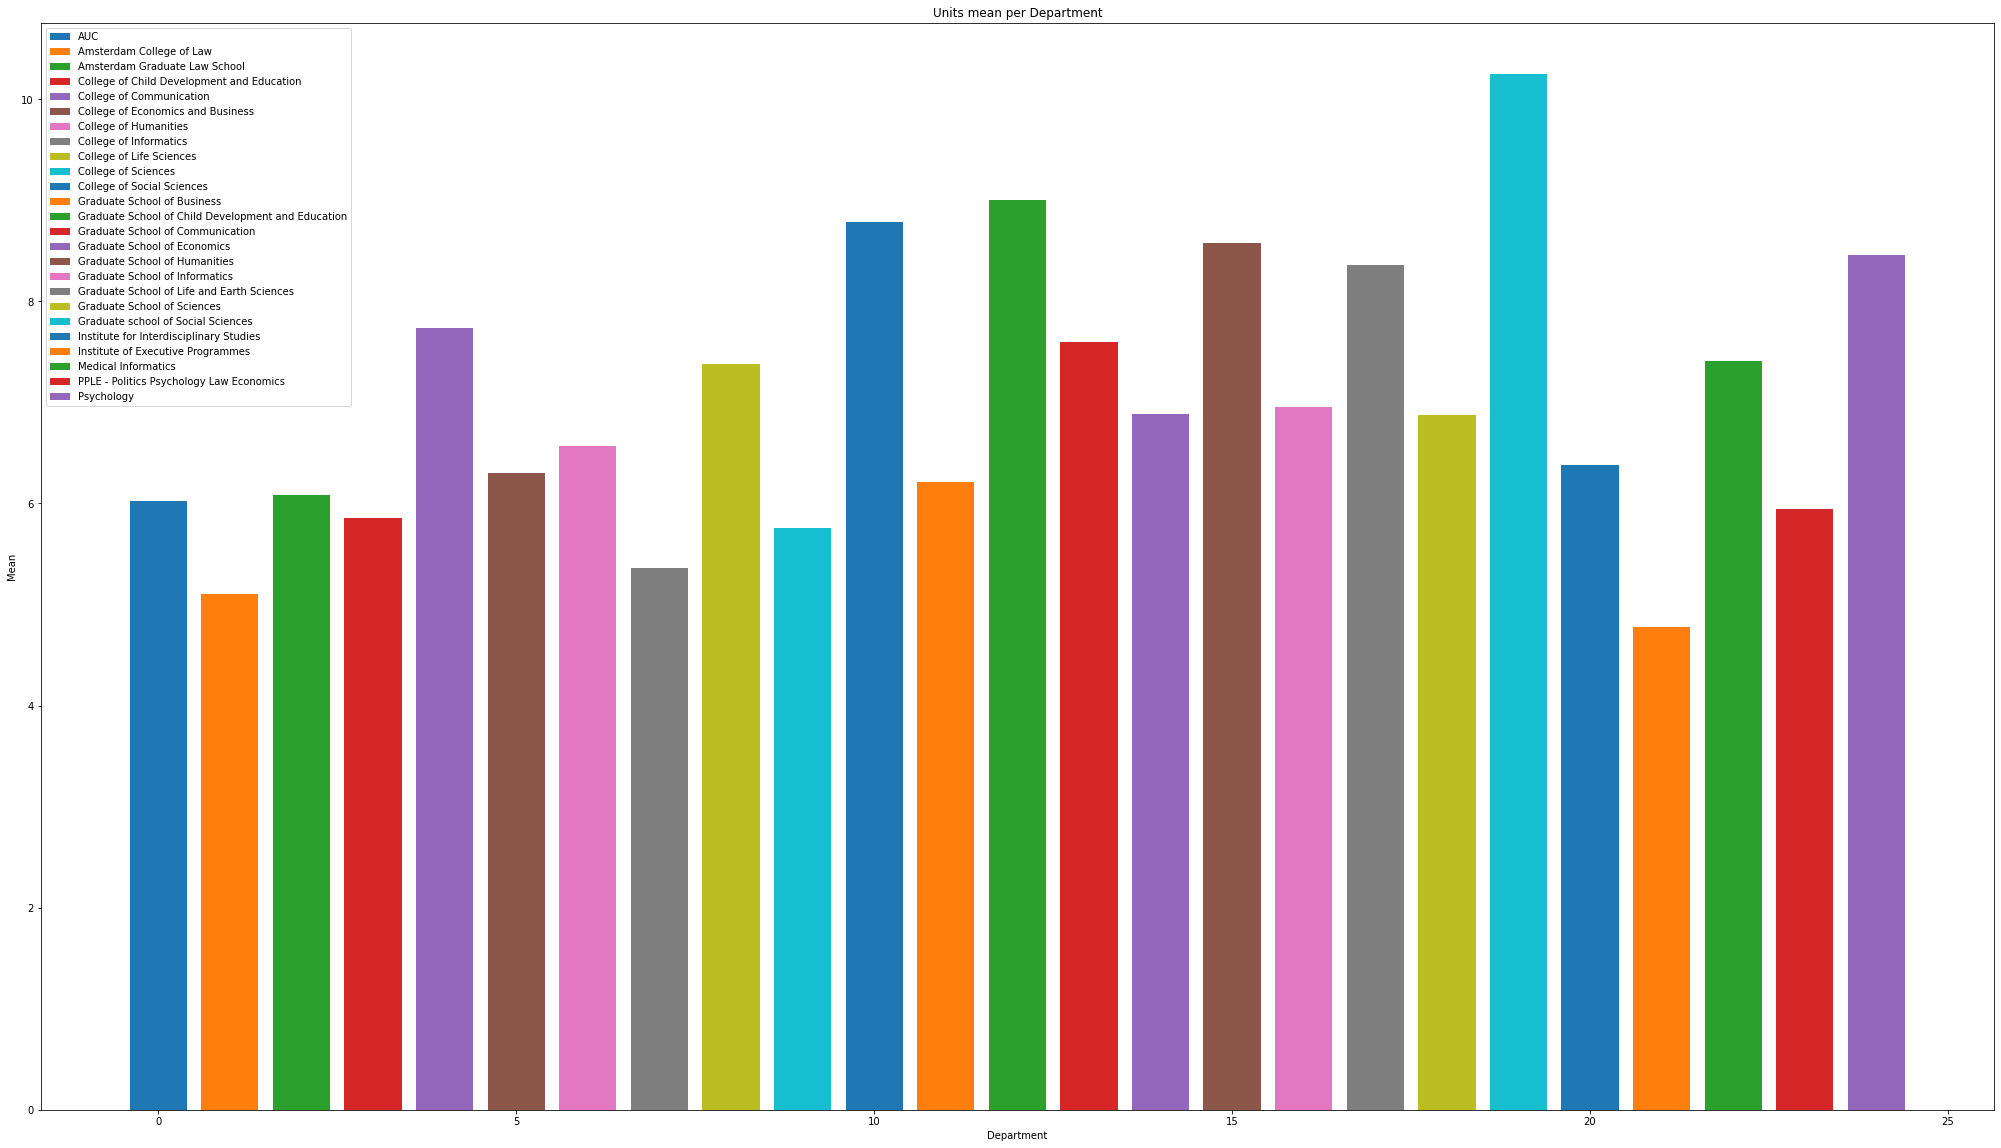

In [30]:
plt.figure(figsize=(35,20))
for index, row in stats.iterrows():
    plt.bar(index, row['mean'], label=row[0])
    plt.legend()
plt.xlabel("Department")
plt.ylabel("Mean")
plt.title("Units mean per Department")
plt.show()


Minimum and maximum of course credits offered in each department:
The departments with minimum of 0 offer optional courses.

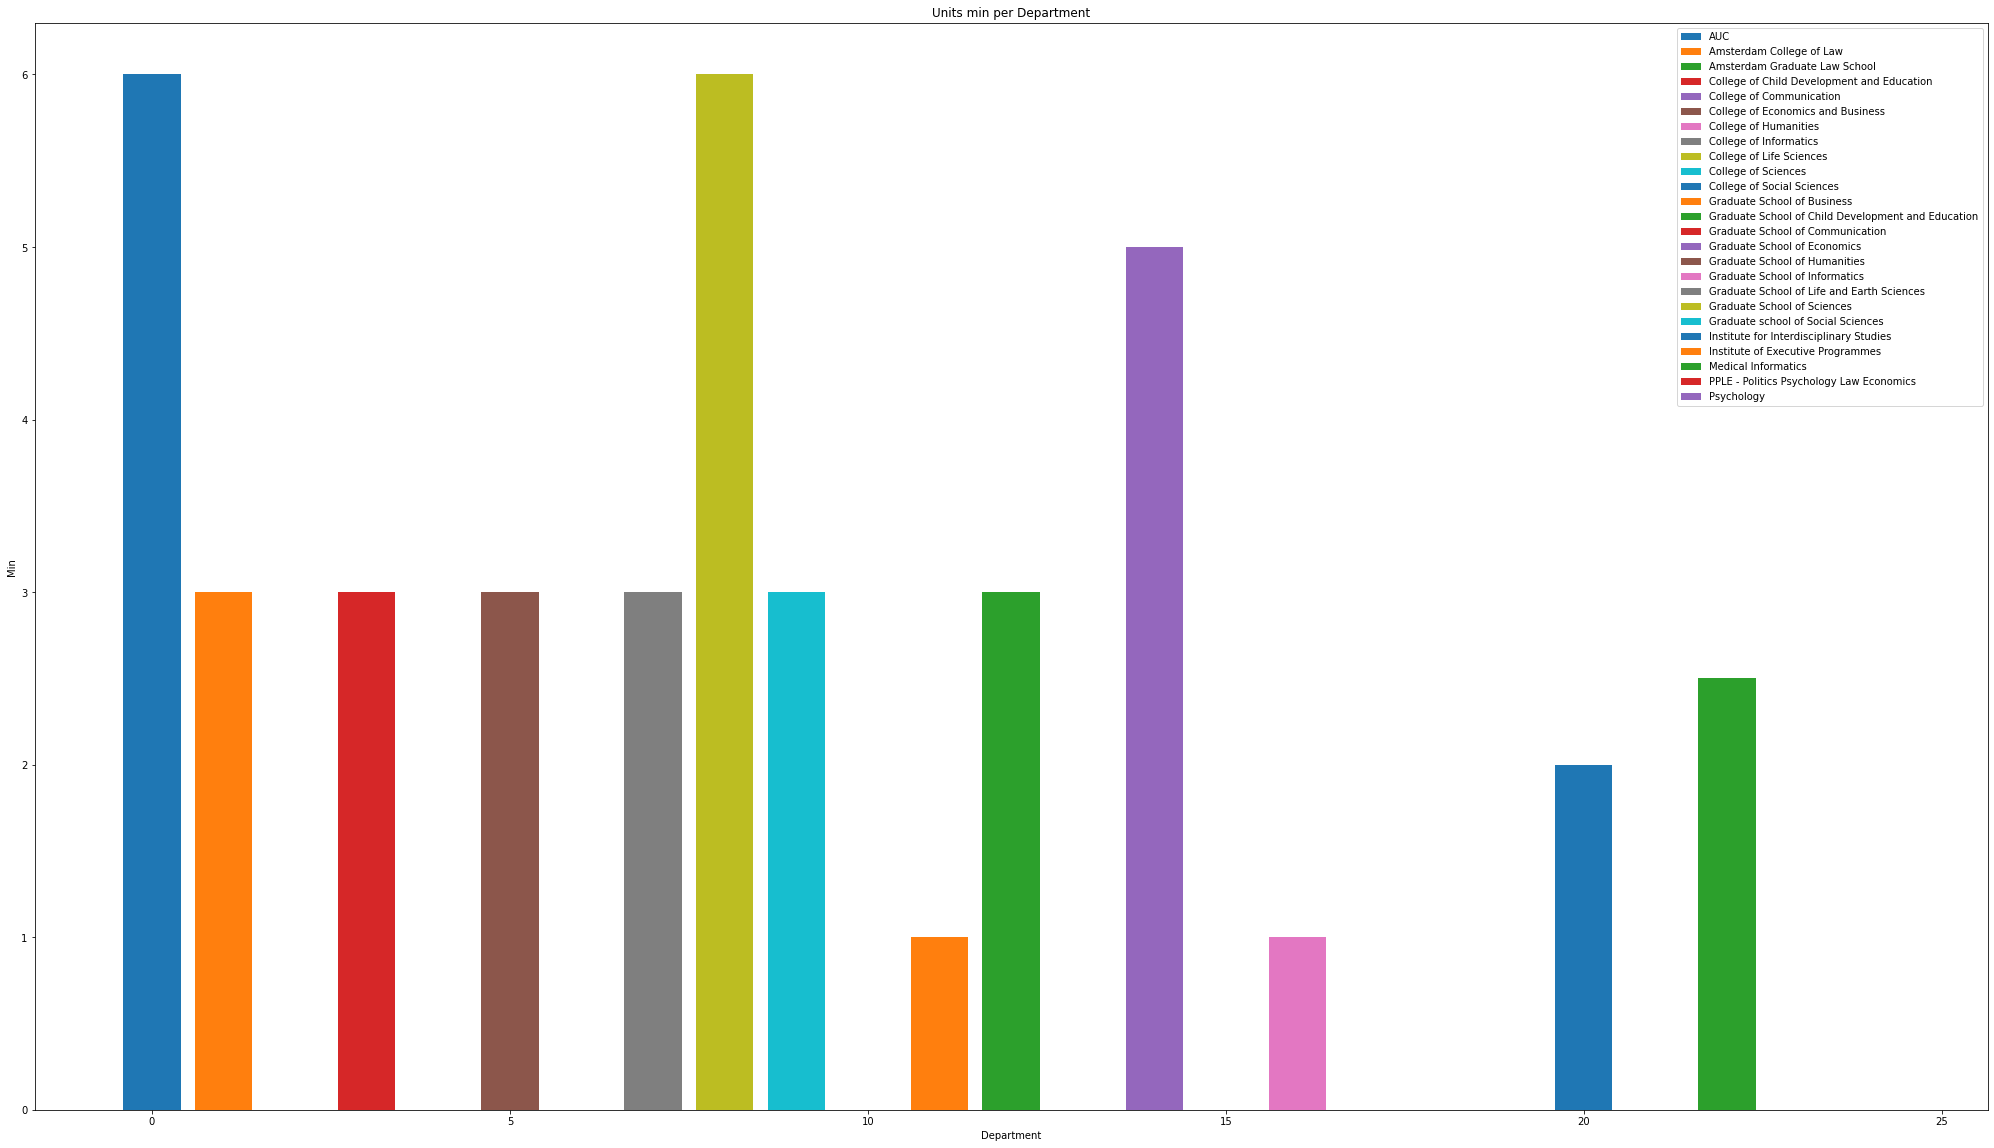

In [ ]:
plt.figure(figsize=(35,20))
for index, row in stats.iterrows():
    plt.bar(index, row['min'], label=row[0])
    plt.legend()
plt.xlabel("Department")
plt.ylabel("Min")
plt.title("Units min per Department")
plt.show()


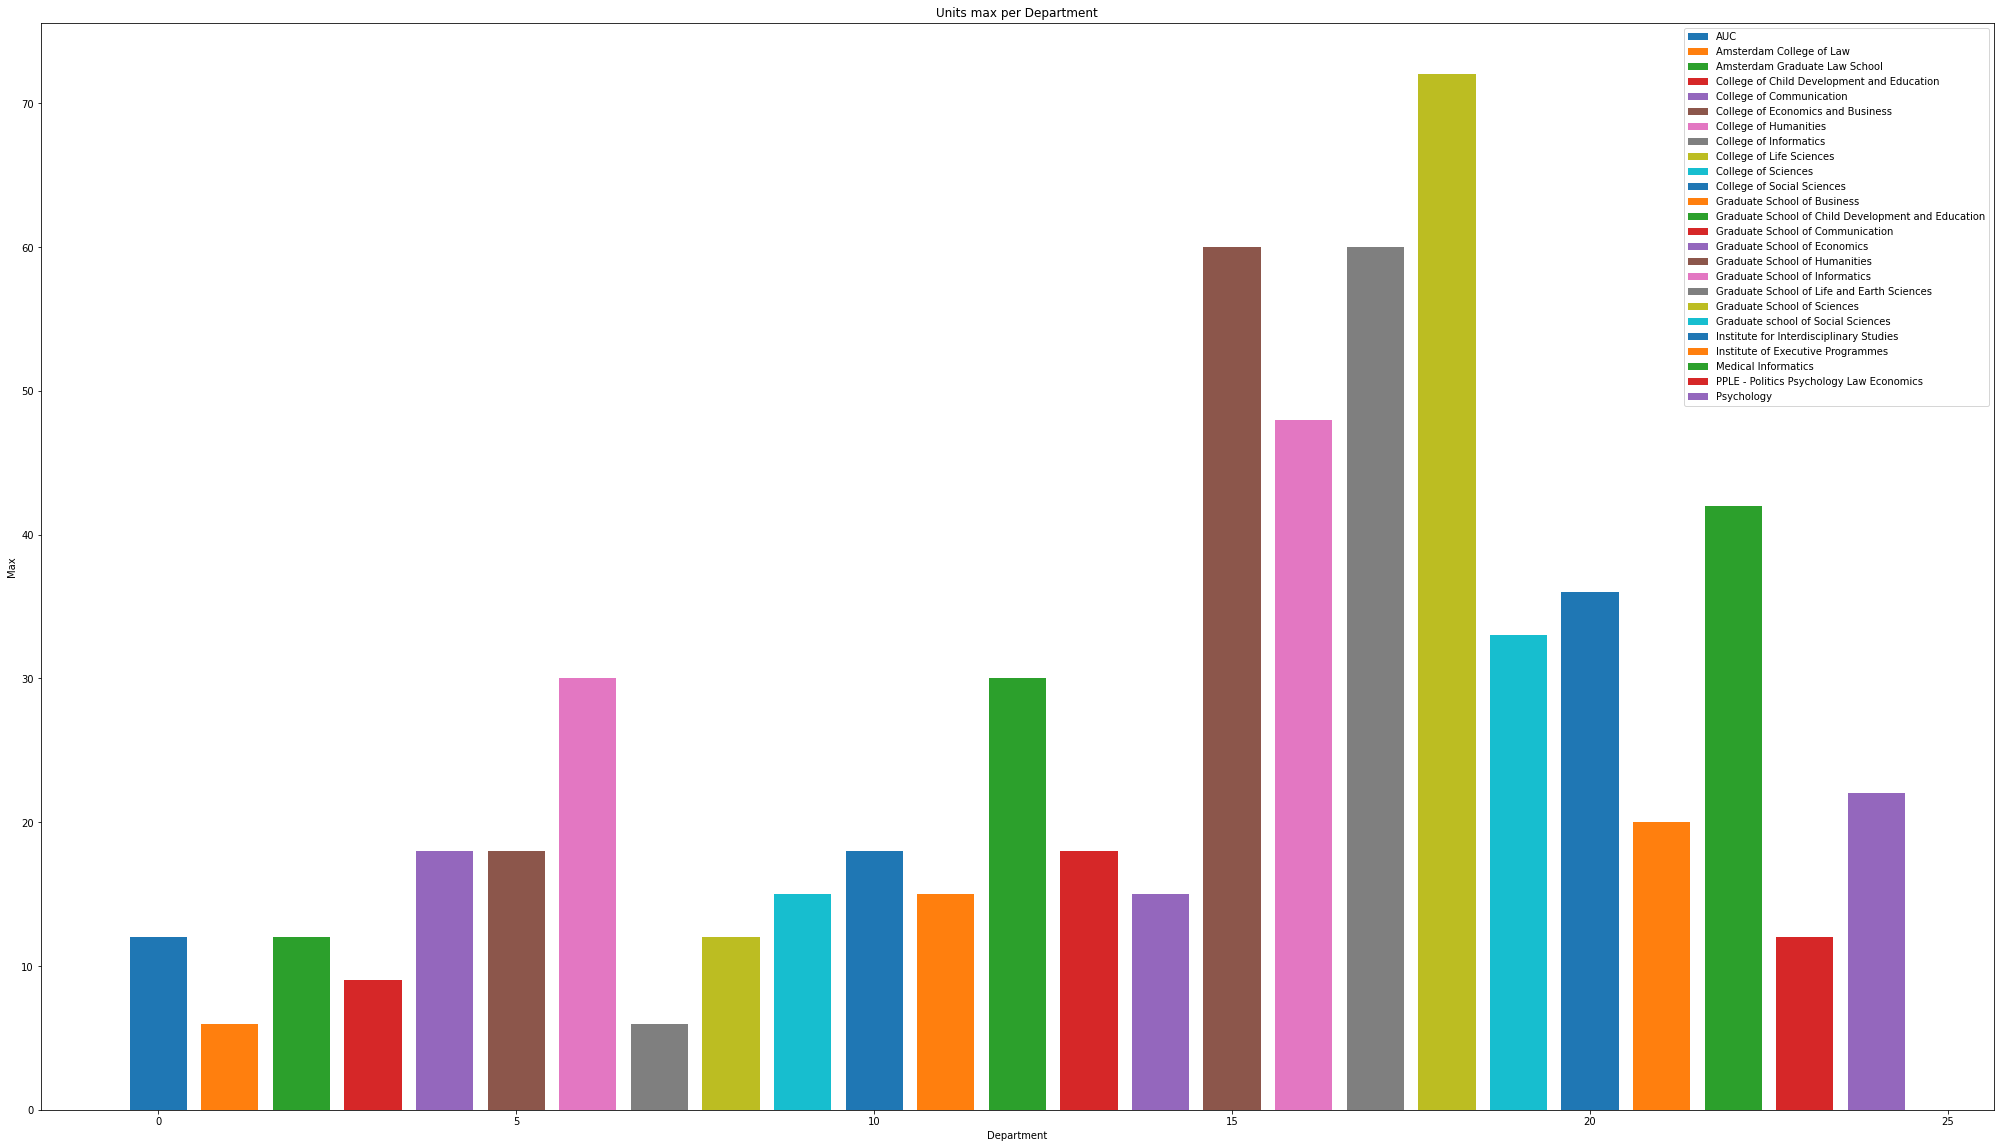

In [32]:
plt.figure(figsize=(35,20))
for index, row in stats.iterrows():
    plt.bar(index, row['max'], label=row[0])
    plt.legend()
plt.xlabel("Department")
plt.ylabel("Max")
plt.title("Units max per Department")
plt.show()


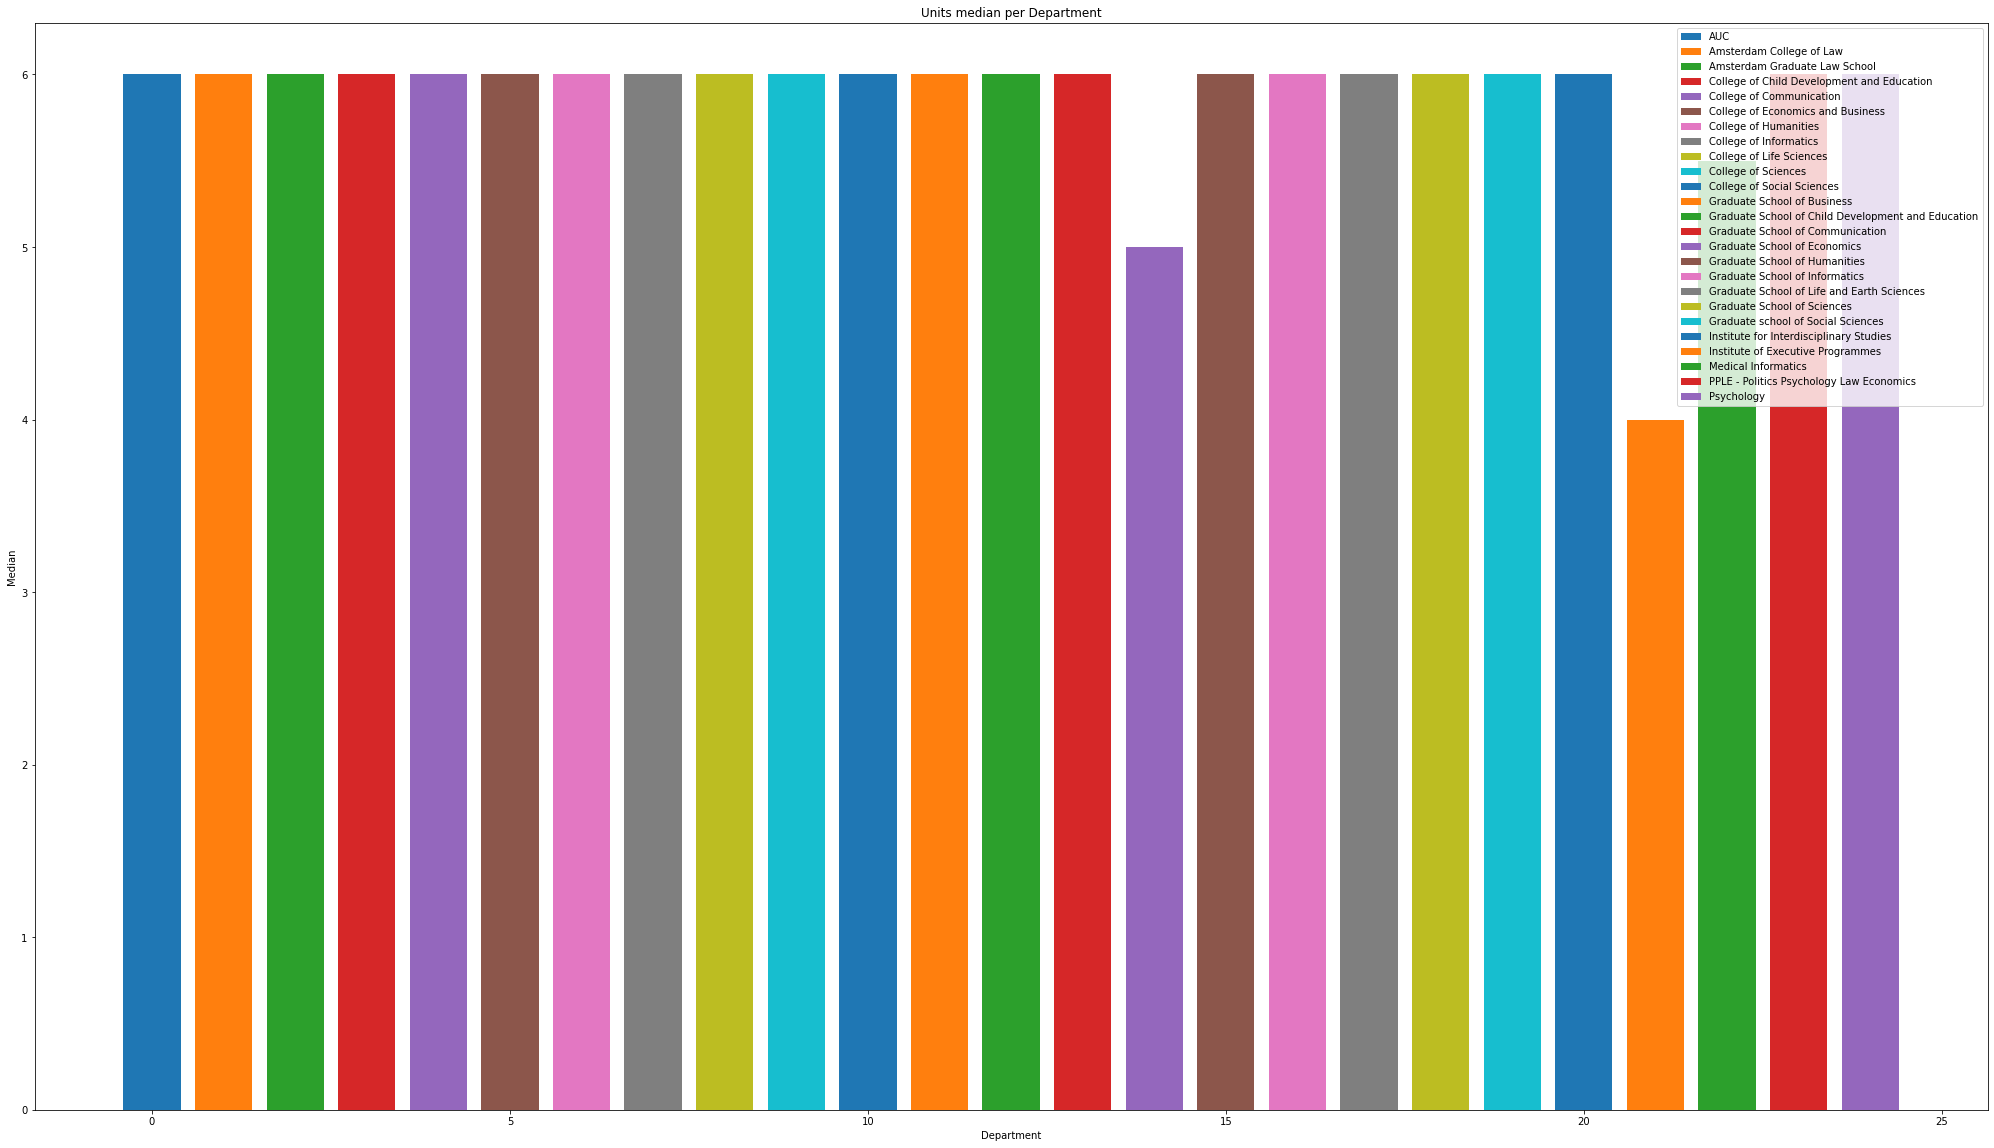

In [33]:
plt.figure(figsize=(35,20))
for index, row in stats.iterrows():
    plt.bar(index, row['median'], label=row[0])
    plt.legend()
plt.xlabel("Department")
plt.ylabel("Median")
plt.title("Units median per Department")
plt.show()


And a side-by-side comparison of statistics for each department:

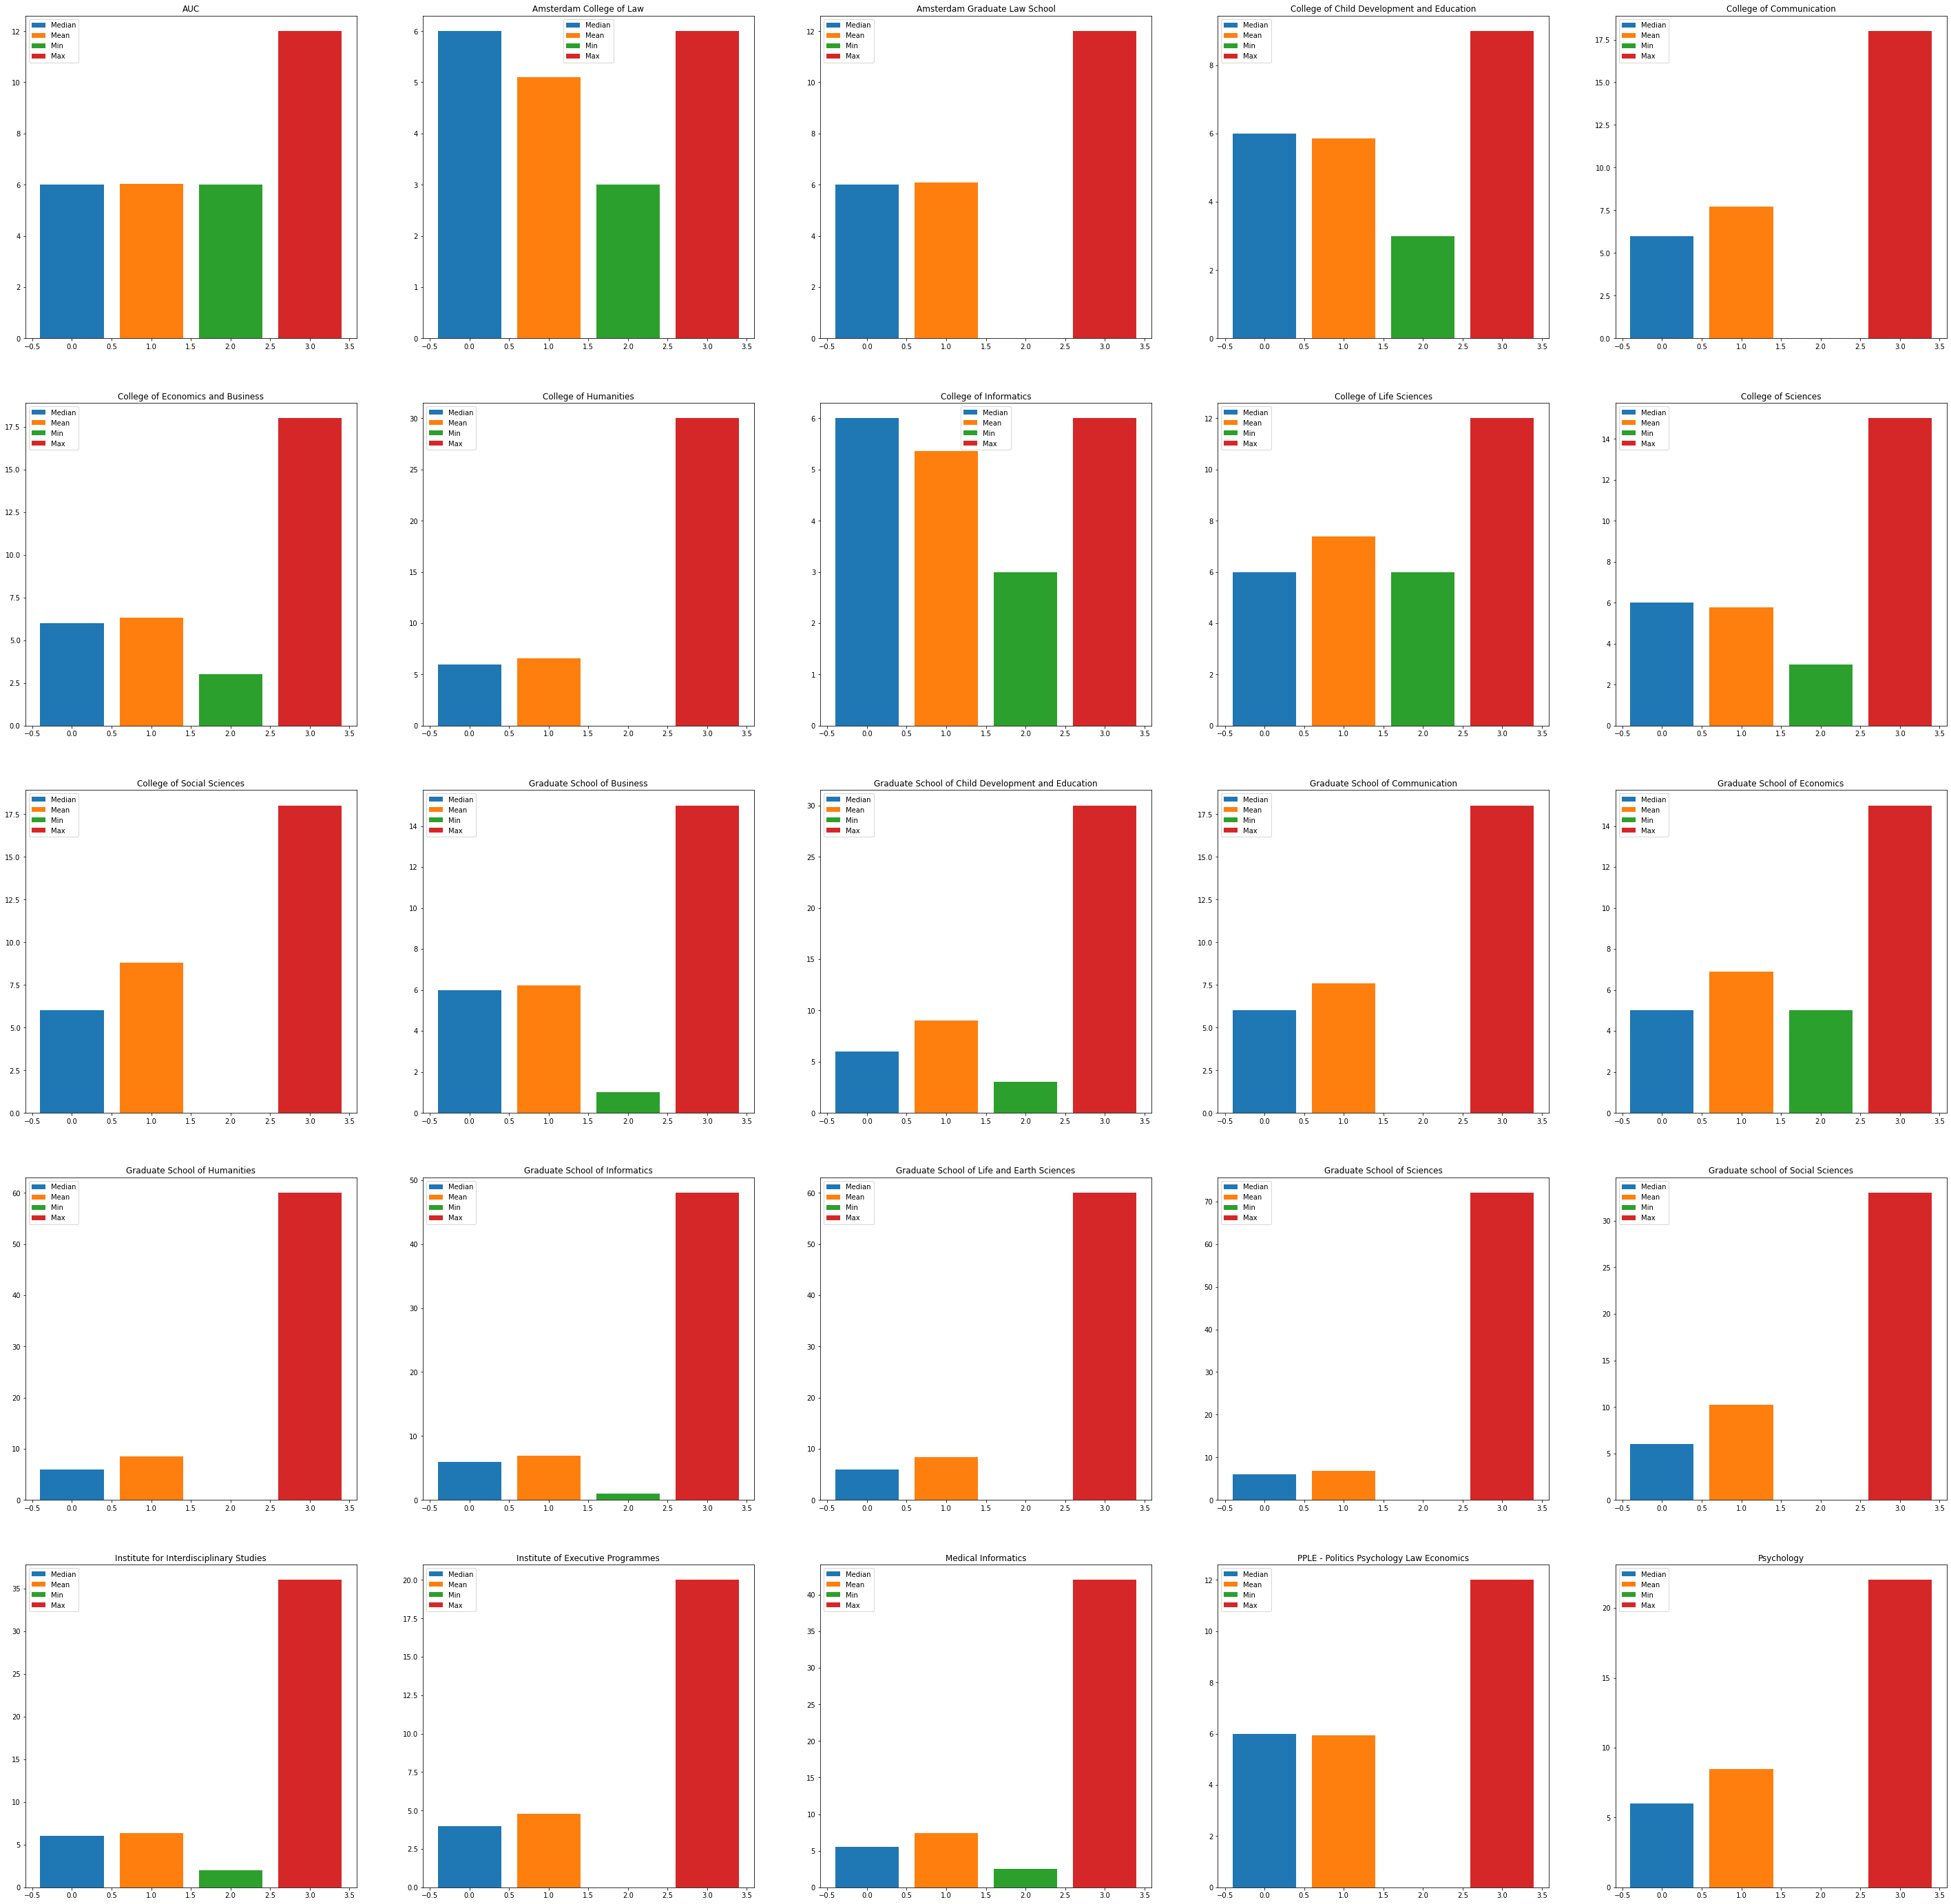

In [39]:
plt.figure(figsize=(50,50))
for index, row in stats.iterrows():
    plt.subplot(5,5,index+1)
    plt.title(row[0])
    plt.bar(0, row['median'], label='Median')
    plt.bar(1, row['mean'], label='Mean')
    plt.bar(2, row['min'], label='Min')
    plt.bar(3, row['max'], label='Max')
    plt.legend()
plt.show()


## Frequent Patterns and Apriori

The next step is to find the frequent itemsets in the data. We will use the Apriori algorithm implemented in [`mlxtend`](http://rasbt.github.io/mlxtend/) to find the frequent itemsets.
We preform the algorithm on the dataframe with the merged columns, and (1,1) n-gram range.

In [3]:
df_keywords = pd.read_csv("data/uva_keywords_2022-06-04-16-57-48_266864.csv")

In [4]:
# keep only columns we need
df_keywords = df_keywords[['keywords_1_1', 'Department', 'Course title']]

In [5]:
df_keywords

keywords_1_1  Department  \
0     [('colonialism', 0.3153), ('literature', 0.304...         AUC   
1     [('literacy', 0.4732), ('academic', 0.4421), (...         AUC   
2     [('literature', 0.3591), ('cultural', 0.3162),...         AUC   
3     [('addiction', 0.4446), ('addict', 0.4035), ('...         AUC   
4     [('writing', 0.4873), ('write', 0.4306), ('stu...         AUC   
...                                                 ...         ...   
3224  [('study', 0.4138), ('research', 0.3136), ('se...  Psychology   
3225  [('study', 0.4382), ('academic', 0.3661), ('st...  Psychology   
3226  [('study', 0.4173), ('psychologyor', 0.3909), ...  Psychology   
3227  [('worklife', 0.4307), ('workgroup', 0.3668), ...  Psychology   
3228  [('intervention', 0.4114), ('adolescent', 0.35...  Psychology   

                                           Course title  
0     A Golden Age? History and Heritage of the Dutc...  
1                               Academic Writing Skills  
2                                    Adaptation Studies  
3                                             Addiction  
4                             Advanced Creative Writing  
...                                                 ...  
3224  Theory Development in Social and Organisationa...  
3225                          Tutorials Academic Skills  
3226  Work and Organisational Psychology & Social Ps...  
3227                        Work, Motivation and Health  
3228  Youth Interventions: Theory, Research and Prac...  

[3229 rows x 3 columns]

The keywords we set in the previous section also include full similarity data, an eval and a cleaning step can omit these and keep only an array of words.

In [6]:
keysets = df_keywords['keywords_1_1'].apply(lambda x: eval(x))
print(keysets)

0       [(colonialism, 0.3153), (literature, 0.304), (...
1       [(literacy, 0.4732), (academic, 0.4421), (stud...
2       [(literature, 0.3591), (cultural, 0.3162), (ad...
3       [(addiction, 0.4446), (addict, 0.4035), (opiat...
4       [(writing, 0.4873), (write, 0.4306), (student,...
                              ...                        
3224    [(study, 0.4138), (research, 0.3136), (seminar...
3225    [(study, 0.4382), (academic, 0.3661), (student...
3226    [(study, 0.4173), (psychologyor, 0.3909), (psy...
3227    [(worklife, 0.4307), (workgroup, 0.3668), (wor...
3228    [(intervention, 0.4114), (adolescent, 0.3579),...
Name: keywords_1_1, Length: 3229, dtype: object


In [7]:
cleaned_keysets = []
for kt in keysets:
    temp_arr = [x[0] for x in kt]
    cleaned_keysets.append(temp_arr)

cleaned_keysets

[['colonialism', 'literature', 'topic', 'amsterdam', 'century'],
 ['literacy', 'academic', 'study', 'interdisciplinarity', 'writing'],
 ['literature', 'cultural', 'adaptation', 'study', 'culture'],
 ['addiction', 'addict', 'opiate', 'addictive', 'amphetamine'],
 ['writing', 'write', 'student', 'learns', 'creative'],
 ['tectonics', 'tectonic', 'geological', 'mineralogy', 'geochemical'],
 ['macroeconomics',
  'macroeconomic',
  'macroeconomist',
  'recession',
  'austerity'],
 ['microeconomics', 'microeconomic', 'macroeconomics', 'economics', 'demand'],
 ['programming', 'programmer', 'proficiency', 'program', 'student'],
 ['study', 'spss', 'statistical', 'analyze', 'student'],
 ['researchwriting', 'academic', 'writing', 'scholarly', 'academia'],
 ['rhetorician', 'rhetoric', 'philosopher', 'philosophical', 'speech'],
 ['anthropology', 'ethnography', 'postcolonial', 'activism', 'decolonialized'],
 ['arabic', 'arab', 'language', 'basic', 'text'],
 ['arabic', 'arab', 'language', 'egyptian', 

In [11]:
df_keywords['cleaned_keywords'] = cleaned_keysets
df_keywords

keywords_1_1  Department  \
0     [('colonialism', 0.3153), ('literature', 0.304...         AUC   
1     [('literacy', 0.4732), ('academic', 0.4421), (...         AUC   
2     [('literature', 0.3591), ('cultural', 0.3162),...         AUC   
3     [('addiction', 0.4446), ('addict', 0.4035), ('...         AUC   
4     [('writing', 0.4873), ('write', 0.4306), ('stu...         AUC   
...                                                 ...         ...   
3224  [('study', 0.4138), ('research', 0.3136), ('se...  Psychology   
3225  [('study', 0.4382), ('academic', 0.3661), ('st...  Psychology   
3226  [('study', 0.4173), ('psychologyor', 0.3909), ...  Psychology   
3227  [('worklife', 0.4307), ('workgroup', 0.3668), ...  Psychology   
3228  [('intervention', 0.4114), ('adolescent', 0.35...  Psychology   

                                           Course title  \
0     A Golden Age? History and Heritage of the Dutc...   
1                               Academic Writing Skills   
2                                    Adaptation Studies   
3                                             Addiction   
4                             Advanced Creative Writing   
...                                                 ...   
3224  Theory Development in Social and Organisationa...   
3225                          Tutorials Academic Skills   
3226  Work and Organisational Psychology & Social Ps...   
3227                        Work, Motivation and Health   
3228  Youth Interventions: Theory, Research and Prac...   

                                       cleaned_keywords  
0     [colonialism, literature, topic, amsterdam, ce...  
1     [literacy, academic, study, interdisciplinarit...  
2     [literature, cultural, adaptation, study, cult...  
3     [addiction, addict, opiate, addictive, ampheta...  
4           [writing, write, student, learns, creative]  
...                                                 ...  
3224    [study, research, seminar, develop, leadership]  
3225  [study, academic, student, assessment, neurops...  
3226  [study, psychologyor, psychologypart, psycholo...  
3227  [worklife, workgroup, workgroups, occupational...  
3228  [intervention, adolescent, youth, study, preve...  

[3229 rows x 4 columns]

`mlxtend` includes a tool for preprocessing the itemsets and creating a matrix of transaction data.

In [8]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(cleaned_keysets).transform(cleaned_keysets)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

10    11e    12e  1830s  5354asip3y  aachen  abiotic  abioticstress  \
0     False  False  False  False       False   False    False          False   
1     False  False  False  False       False   False    False          False   
2     False  False  False  False       False   False    False          False   
3     False  False  False  False       False   False    False          False   
4     False  False  False  False       False   False    False          False   
...     ...    ...    ...    ...         ...     ...      ...            ...   
3224  False  False  False  False       False   False    False          False   
3225  False  False  False  False       False   False    False          False   
3226  False  False  False  False       False   False    False          False   
3227  False  False  False  False       False   False    False          False   
3228  False  False  False  False       False   False    False          False   

        abm  abstraction  ...  wwwebinternshipsnl  yemen  young  youth  \
0     False        False  ...               False  False  False  False   
1     False        False  ...               False  False  False  False   
2     False        False  ...               False  False  False  False   
3     False        False  ...               False  False  False  False   
4     False        False  ...               False  False  False  False   
...     ...          ...  ...                 ...    ...    ...    ...   
3224  False        False  ...               False  False  False  False   
3225  False        False  ...               False  False  False  False   
3226  False        False  ...               False  False  False  False   
3227  False        False  ...               False  False  False  False   
3228  False        False  ...               False  False  False   True   

      youthrelated  yugoslav  yugoslavia  zelfstudie   zijn  zoning  
0            False     False       False       False  False   False  
1            False     False       False       False  False   False  
2            False     False       False       False  False   False  
3            False     False       False       False  False   False  
4            False     False       False       False  False   False  
...            ...       ...         ...         ...    ...     ...  
3224         False     False       False       False  False   False  
3225         False     False       False       False  False   False  
3226         False     False       False       False  False   False  
3227         False     False       False       False  False   False  
3228         False     False       False       False  False   False  

[3229 rows x 3088 columns]

### Apriori Parameters
It is important to find a good support for the frequent itemsets. Since the data is quite sparse and the courses are quite different (especially in the department of _Graduate School of Humanities_ or other departments with high course count), we will set the support to a low value to obtain a good enough result. Otherwise, almost all of the departments will return a few trivial itemsets such as `['study', 'student', 'exam']`.

In [9]:
from mlxtend.frequent_patterns import apriori
apriori(df, min_support=0.25)

support itemsets
0  0.306596   (2751)

Without categorising the departments, the results are still trivial even for 0.005 support.

In [10]:
apriori(df, min_support=0.005, use_colnames=True)

support                                           itemsets
0    0.050790                                         (academic)
1    0.010220                                       (accounting)
2    0.031898                                        (amsterdam)
3    0.015175                                          (analyse)
4    0.008981                                  (anthropological)
..        ...                                                ...
367  0.011459                  (student, tutor, tutoring, study)
368  0.025395  (amsterdam, vrije, universiteit, registration,...
369  0.006813     (part, website, course, mastermath, programme)
370  0.008052  (procedure, registration, mastermath, programm...
371  0.011459        (student, lecturer, tutor, tutoring, study)

[372 rows x 2 columns]

In [12]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
# get all unique values in Department column
departments = df_keywords['Department'].unique()
df = {}
for dept in departments:
    print(dept)
    # filter the dataframe to only include rows with the current department
    df_keywords_dept = df_keywords[df_keywords['Department'] == dept]
    # get all cleaned_keywords in it
    cleaned_keywords = df_keywords_dept['cleaned_keywords']
    te = TransactionEncoder()
    te_ary = te.fit(cleaned_keywords).transform(cleaned_keywords)
    df[dept] = pd.DataFrame(te_ary, columns=te.columns_)
    print(df[dept])

AUC
     abundance  academia  academic  accredited  achievement  acting  activism  \
0        False     False     False       False        False   False     False   
1        False     False      True       False        False   False     False   
2        False     False     False       False        False   False     False   
3        False     False     False       False        False   False     False   
4        False     False     False       False        False   False     False   
..         ...       ...       ...         ...          ...     ...       ...   
263      False     False     False       False        False   False     False   
264      False     False     False       False        False   False     False   
265      False     False     False       False        False   False     False   
266      False     False     False       False        False   False     False   
267      False     False     False       False        False   False     False   

     activist  activity

The better approach is to categorise the departments into groups, thus dealing with the problem of sparsity to a greater extent. We can now use a minimum support of 0.05 to obtain non-trivial results in most cases.

In [41]:
from mlxtend.frequent_patterns import apriori
freq_itemsets = {}
for dept in df:
    freq_itemsets[dept] = apriori(df[dept], min_support=0.05, use_colnames=True)
    print('-------------------')
    print(dept)
    print(freq_itemsets[dept])

-------------------
AUC
    support             itemsets
0  0.059701  (interdisciplinary)
1  0.055970           (language)
2  0.197761            (student)
3  0.279851              (study)
4  0.052239              (topic)
5  0.085821     (student, study)
-------------------
Amsterdam College of Law
     support                                           itemsets
0        0.1                                         (advocate)
1        0.1                                            (basic)
2        0.1                                           (brexit)
3        0.1                                      (comparative)
4        0.1                                    (comprehensive)
..       ...                                                ...
279      0.1  (lawmaking, law, lecture, discrimination, legi...
280      0.1        (economic, judicial, economics, law, study)
281      0.1   (economic, oligopoly, economics, lecture, study)
282      0.1     (essay, methodology, teaching, student, stu

In [42]:
for dept in freq_itemsets:
    temp_df_freqs = freq_itemsets[dept]
    temp_df = pd.DataFrame(temp_df_freqs)
    temp_df.to_csv(f"data/freqs_{dept.replace(' ', '-')}.csv", index=False)

# df_freqs = pd.DataFrame(freq_itemsets[dept])
# df_freqs.to_csv("data/frequent_itemsets.csv", index=False)

In [43]:
df_freqs = {}
for file in os.listdir("data/"):
    if file.startswith("freqs_"):
        df_freqs[file.replace('freqs_', '').replace('.csv', '').replace('-', ' ')] = pd.read_csv(f"data/{file}")

df_freqs = pd.DataFrame(df_freqs.items())
    
# df_freqs = pd.read_csv("data/frequent_itemsets.csv")

### Visualisation
Below is an extensive visualisation of the wordclouds associated with frequent itemsets per department. Note that the more 'generic' departments such as AUC have fewer words and more secialised departments like College of Law or Graduate School of Law have more words that are also relevant to the department.

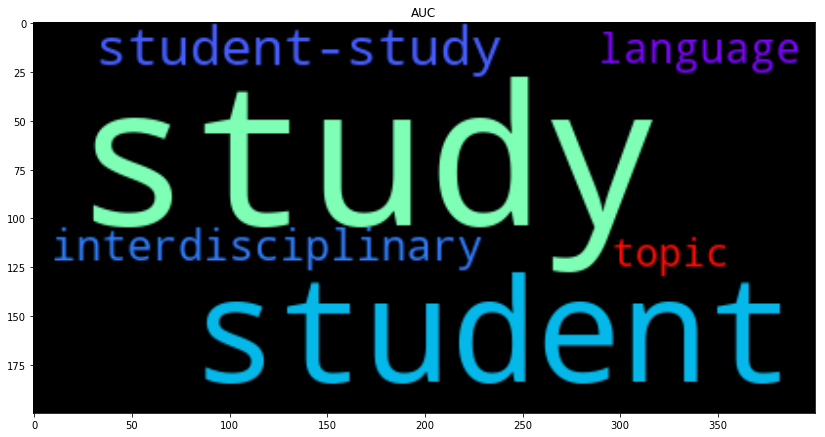

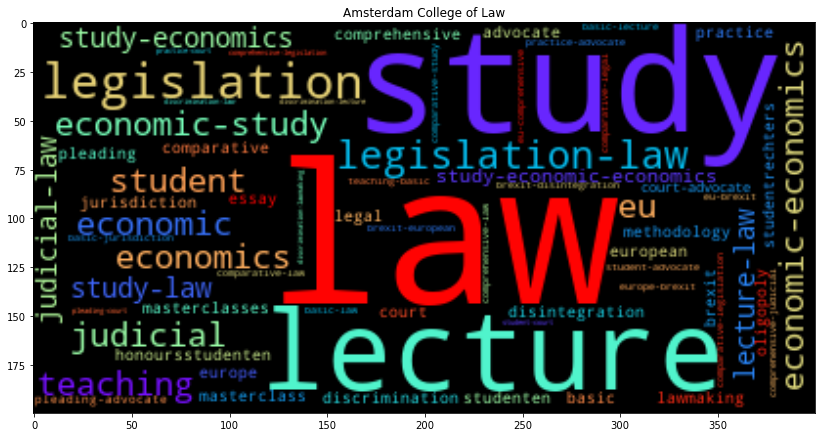

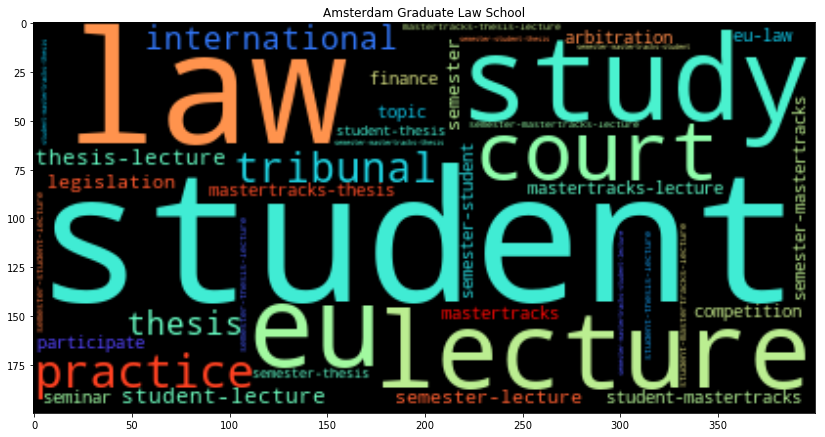

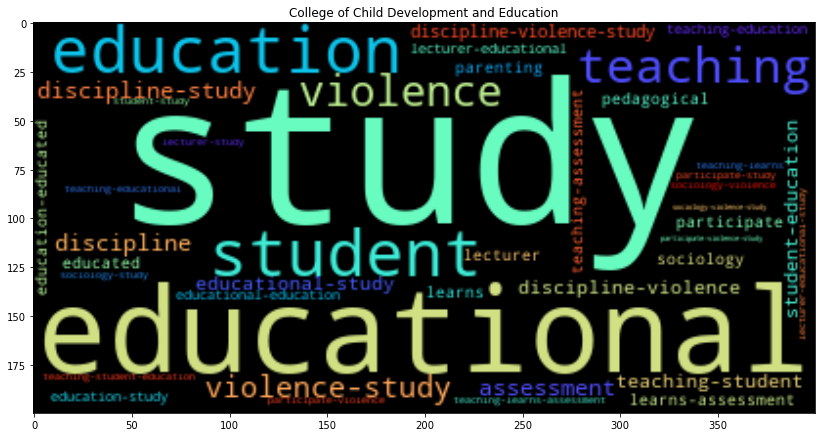

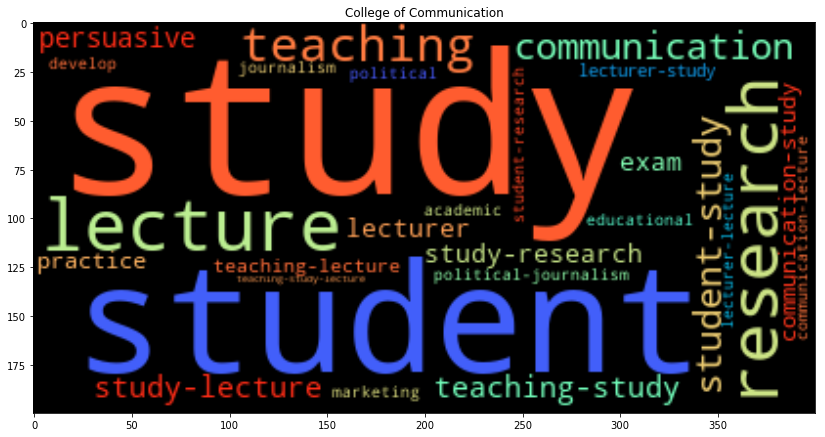

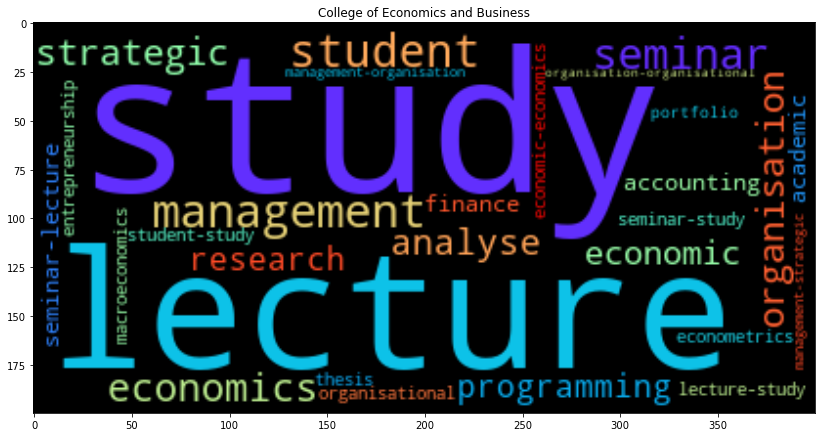

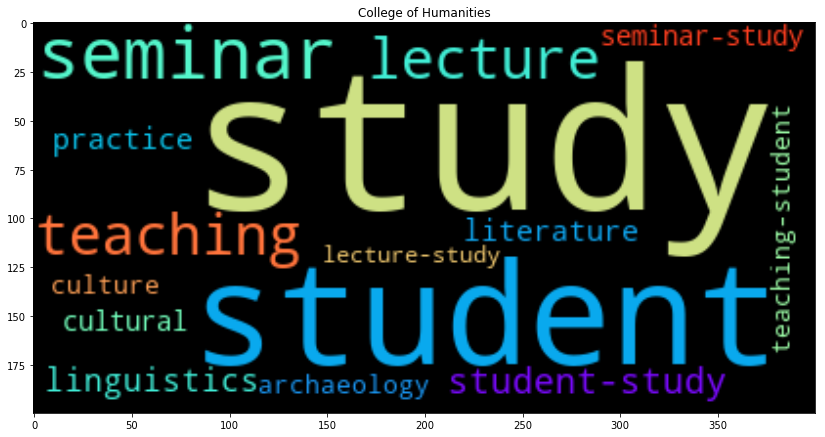

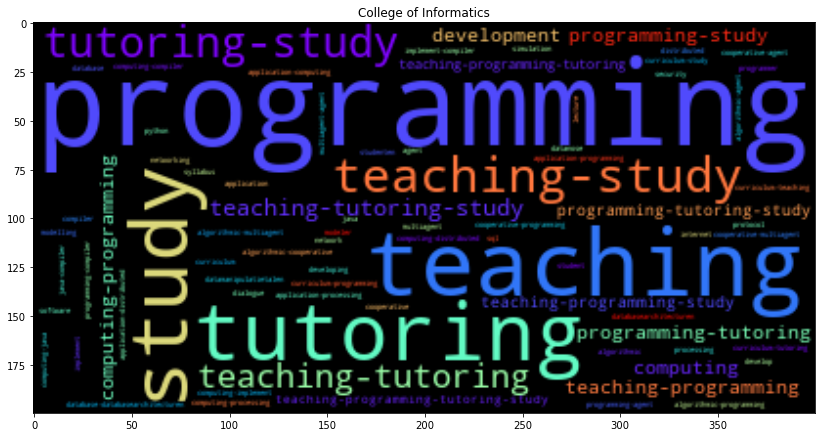

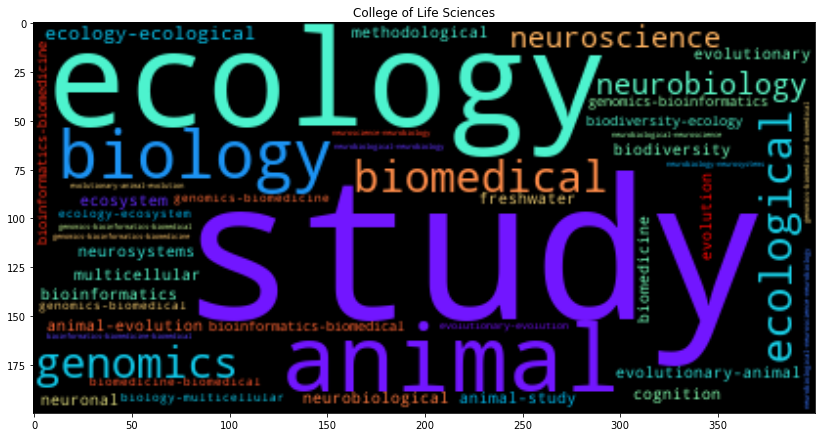

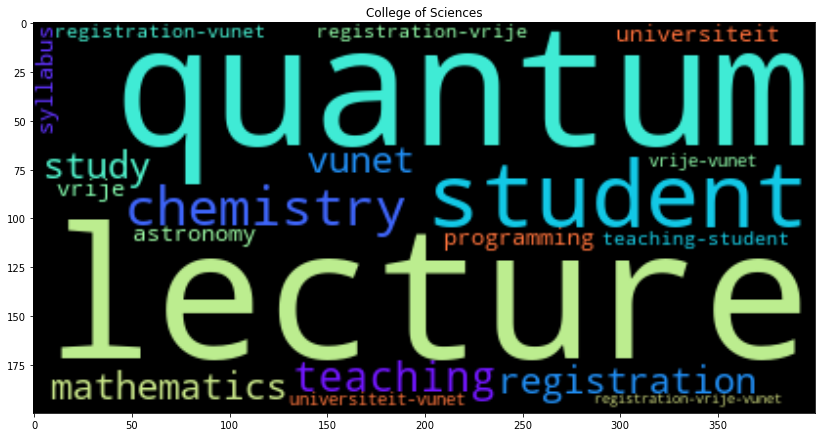

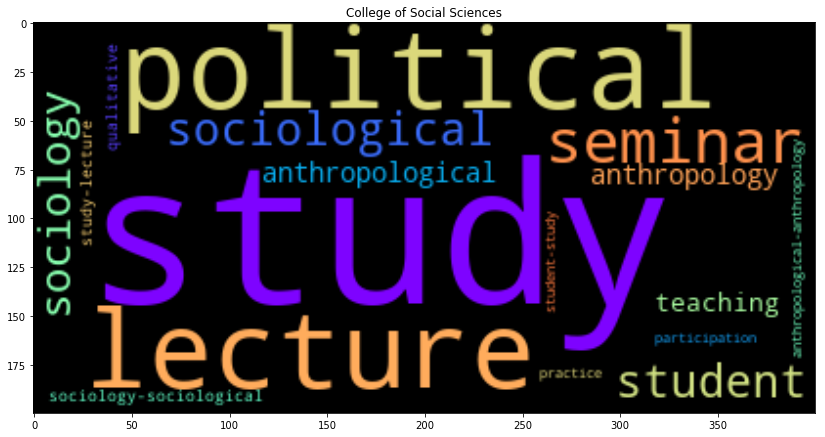

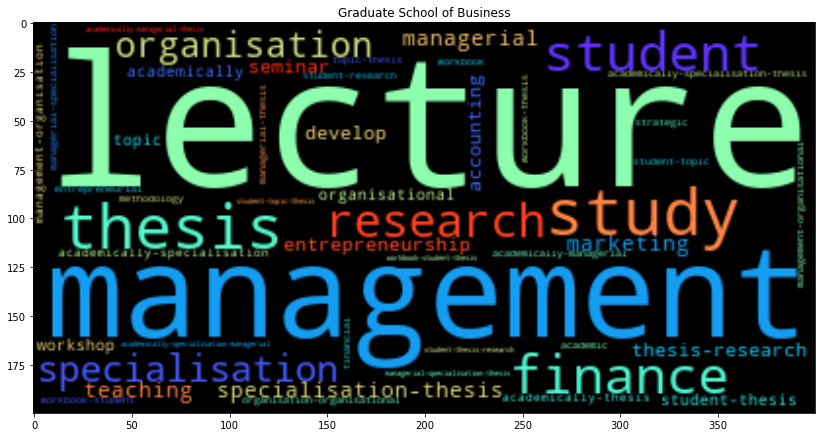

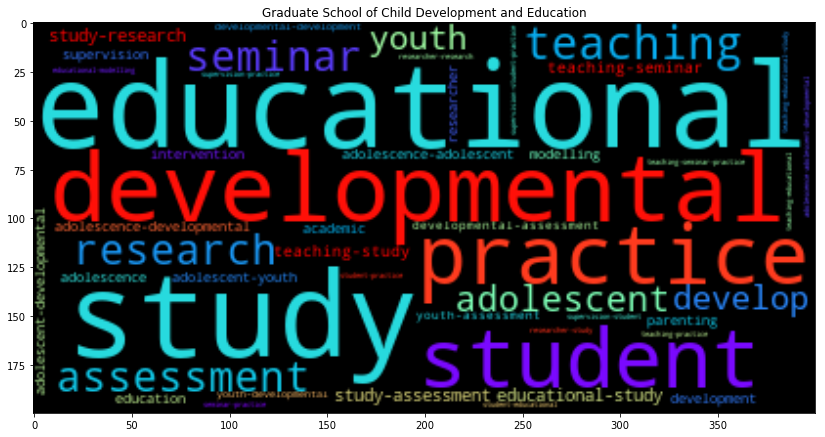

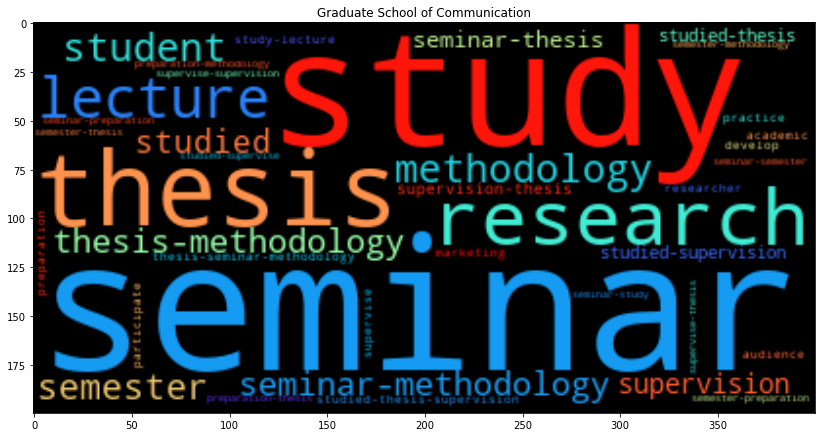

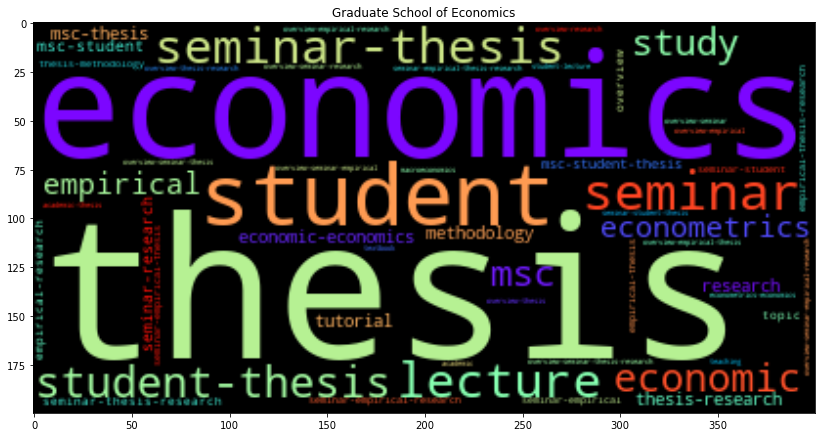

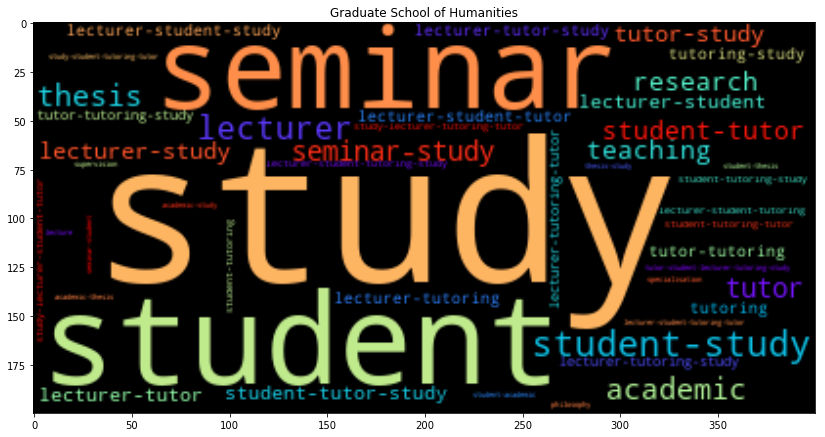

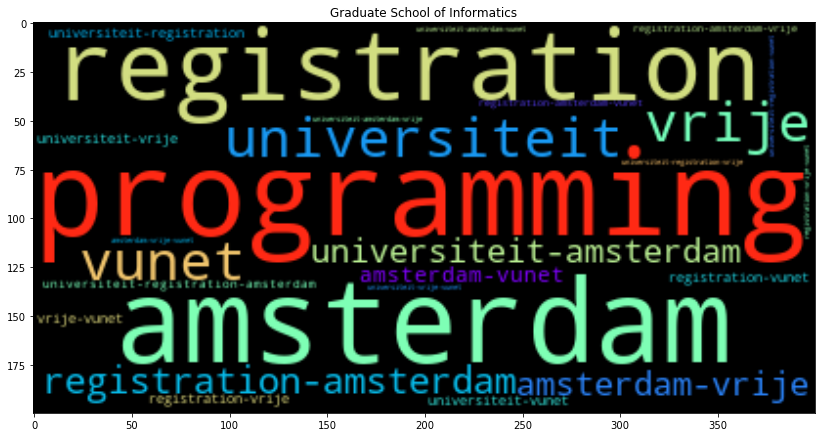

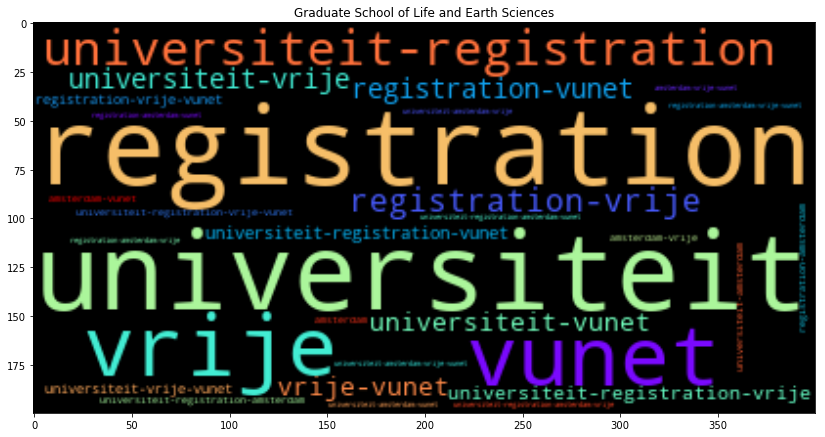

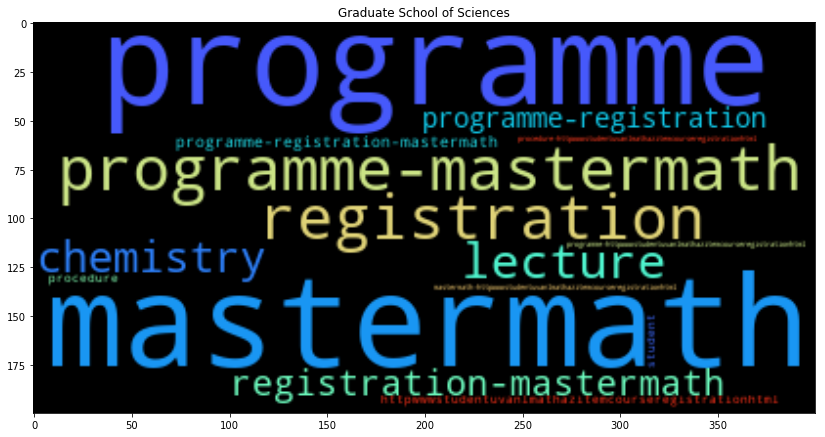

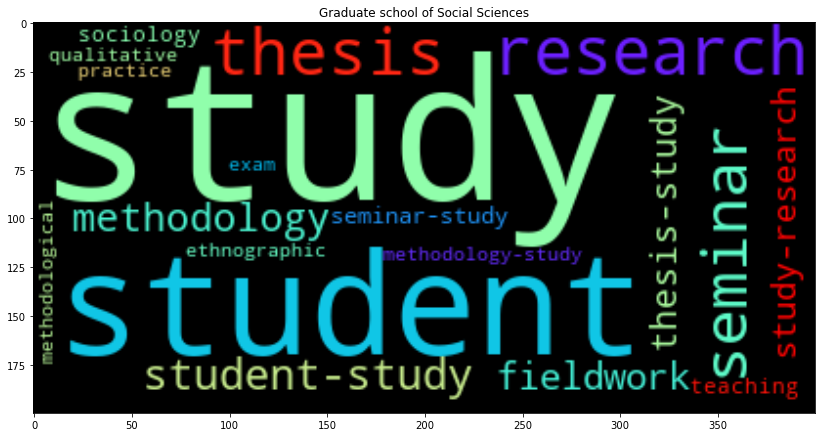

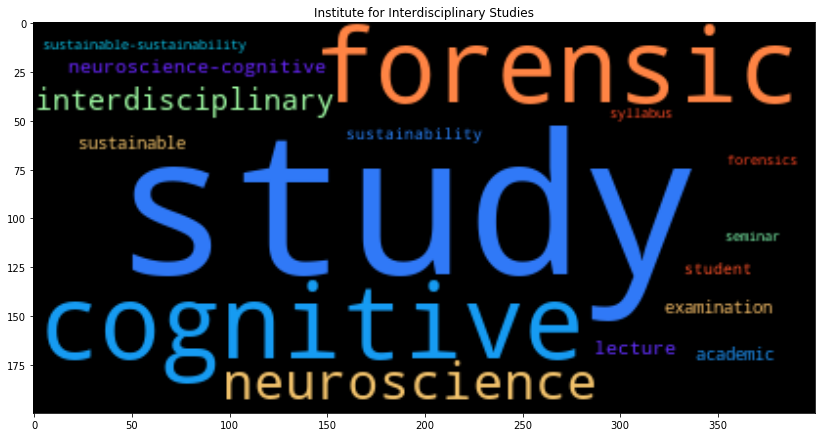

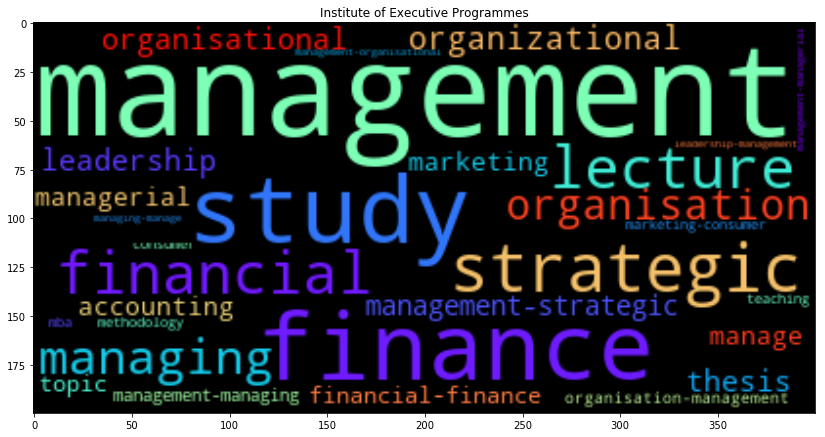

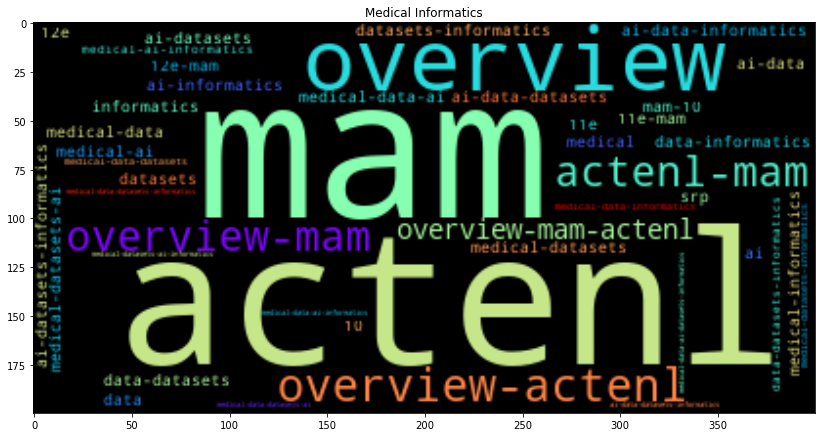

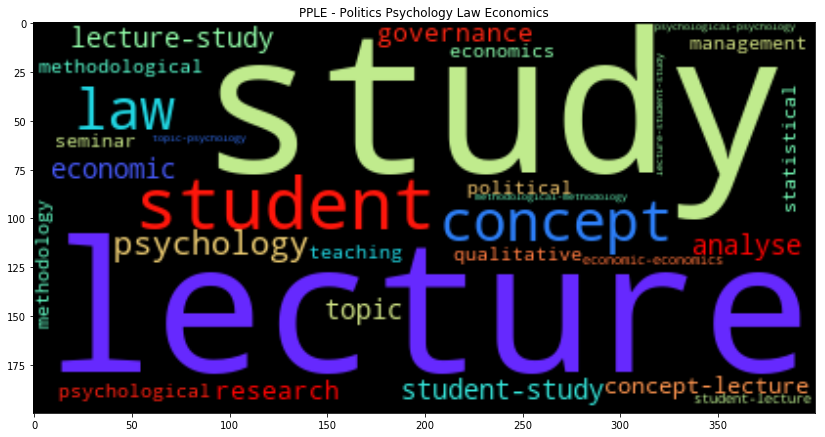

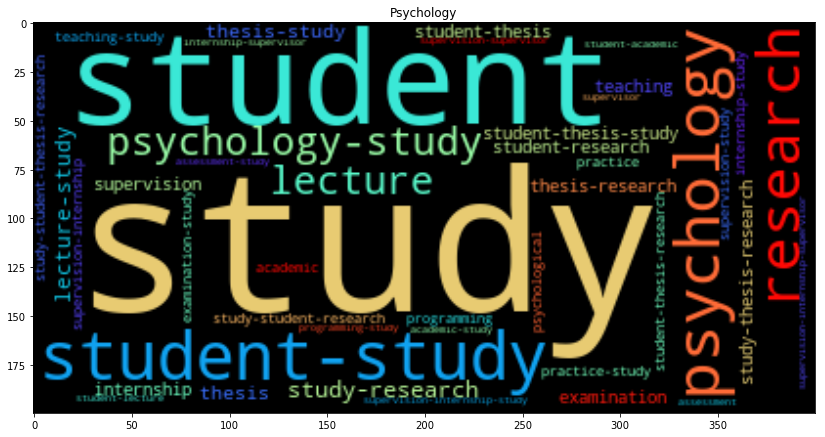

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
for dept in freq_itemsets:
    temp_dict = {}
    cur_dept = freq_itemsets[dept]
    for index, row in cur_dept.iterrows():
        temp_frozenset_to_list = list(row['itemsets'])
        temp_dict['-'.join(temp_frozenset_to_list)] = row['support']

    cloud = WordCloud(max_font_size=100,colormap="rainbow",background_color='black').generate_from_frequencies(temp_dict)
    plt.figure(figsize=(14,10))
    plt.imshow(cloud, interpolation='bilinear')
    #set dept as label for the plot
    plt.title(dept)
    plt.show()

## Association Rules

The `mlxtend` library also includes a handy tool for deriving association rules from the set of frequent itemsets.

In [44]:
from mlxtend.frequent_patterns import association_rules
assoc_rules = {}
for dept in freq_itemsets:
    assoc_rules[dept] = association_rules(res[dept], metric="confidence", min_threshold=0.7)
    print('-------------------')   
    print(dept)
    print(assoc_rules[dept].head())

-------------------
AUC
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []
-------------------
Amsterdam College of Law
  antecedents consequents  antecedent support  consequent support  support  \
0     (court)  (advocate)                 0.1                 0.1      0.1   
1  (advocate)     (court)                 0.1                 0.1      0.1   
2  (pleading)  (advocate)                 0.1                 0.1      0.1   
3  (advocate)  (pleading)                 0.1                 0.1      0.1   
4  (practice)  (advocate)                 0.1                 0.1      0.1   

   confidence  lift  leverage  conviction  
0         1.0  10.0      0.09         inf  
1         1.0  10.0      0.09         inf  
2         1.0  10.0      0.09         inf  
3         1.0  10.0      0.09         inf  
4         1.0  10.0      0.09         inf  
-------------------
Amsterdam Graduate Law Scho

In [45]:
for dept in assoc_rules:
    temp_df_rules = assoc_rules[dept]
    temp_df = pd.DataFrame(temp_df_rules)
    temp_df.to_csv(f"data/rules_{dept.replace(' ', '-')}.csv", index=False)

In [46]:
df_rules = {}
import os
#iterate over files in data/ with pattern rules_*.csv
for file in os.listdir("data/"):
    if file.startswith("rules_"):
        df_rules[file.replace('rules_', '').replace('.csv', '').replace('-', ' ')] = pd.read_csv(f"data/{file}")
        
df_rules = df_rules['new']

In [ ]:
df_rules['Rules']

0     Empty DataFrame\r\nColumns: [antecedents, cons...
1                  antecedents                      ...
2                      antecedents                  ...
3                     antecedents             conseq...
4                antecedents   consequents  antecede...
5             antecedents     consequents  anteceden...
6     Empty DataFrame\r\nColumns: [antecedents, cons...
7                     antecedents                   ...
8                                       antecedents ...
9                   antecedents            consequen...
10    Empty DataFrame\r\nColumns: [antecedents, cons...
11                                       antecedents...
12                         antecedents              ...
13                     antecedents                  ...
14                   antecedents                    ...
15                  antecedents                     ...
16            antecedents                           ...
17            antecedents                       

### Visualisations
The best way to visualise the distribution of rules is to use a scatterplot, showing the relation between confidence and support of each rule. It also shows us the number of rules per department, which is interesting. For example, the College of Humanitarian Sciences has the most rules while AUC (with higher topic range but fewer courses) has no rules.

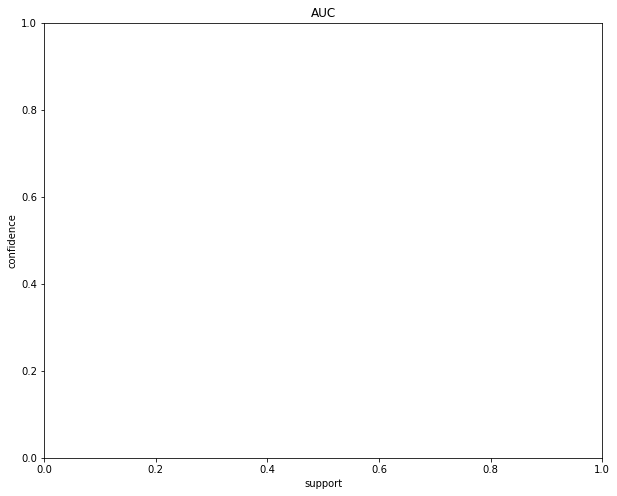

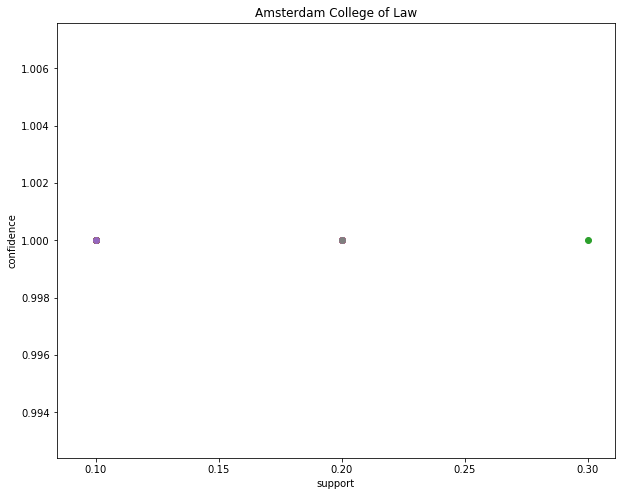

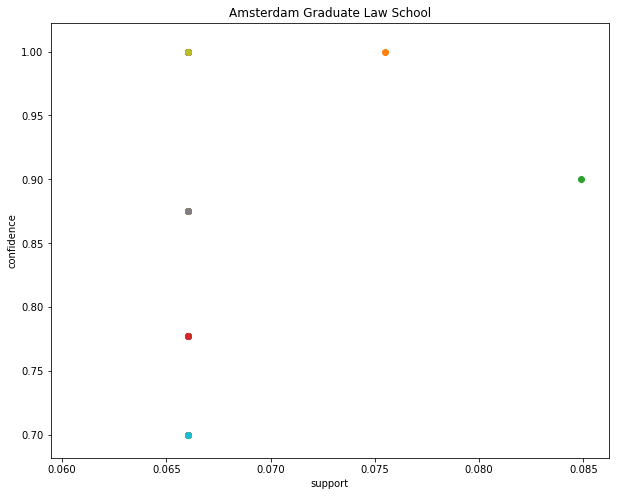

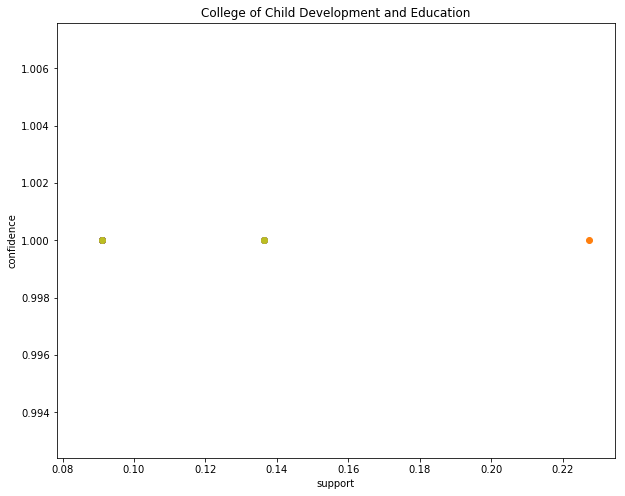

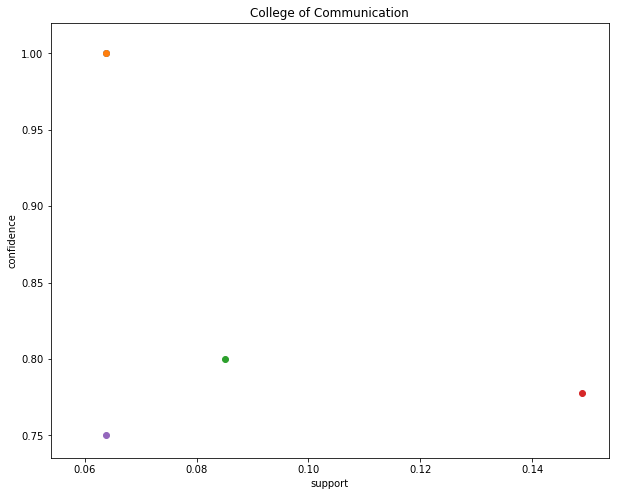

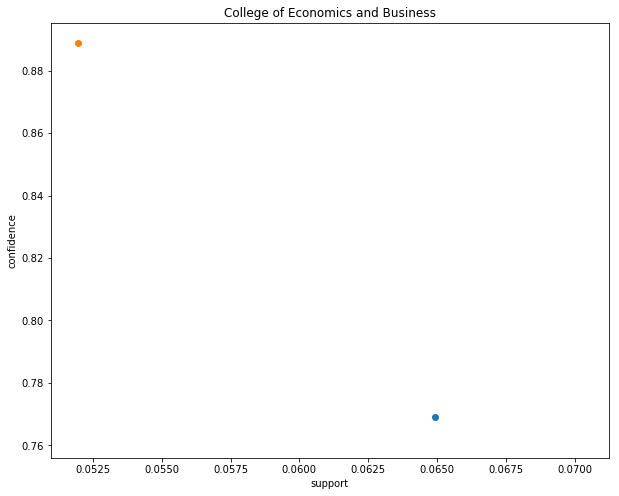

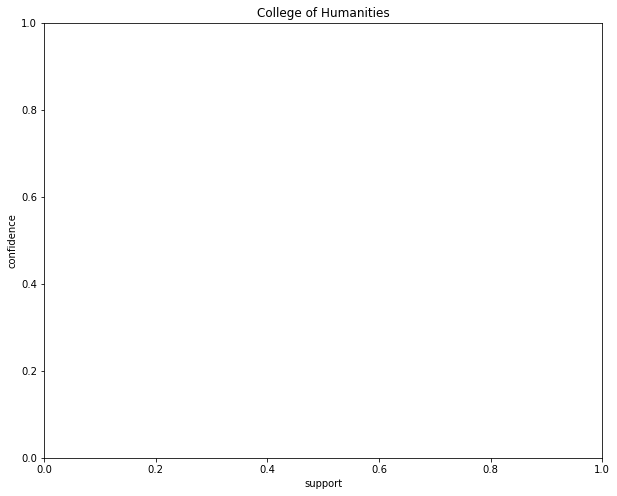

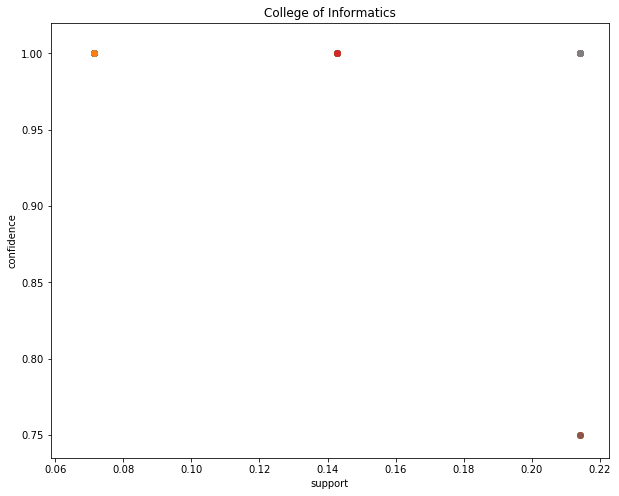

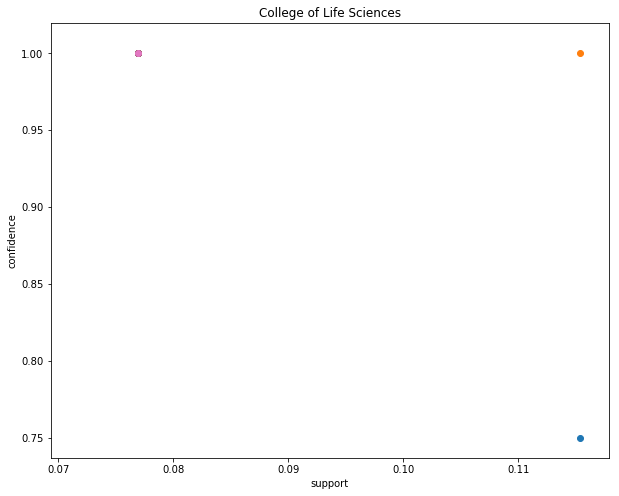

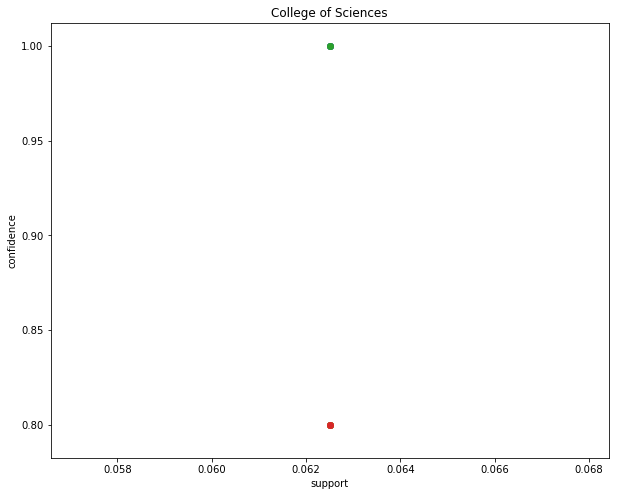

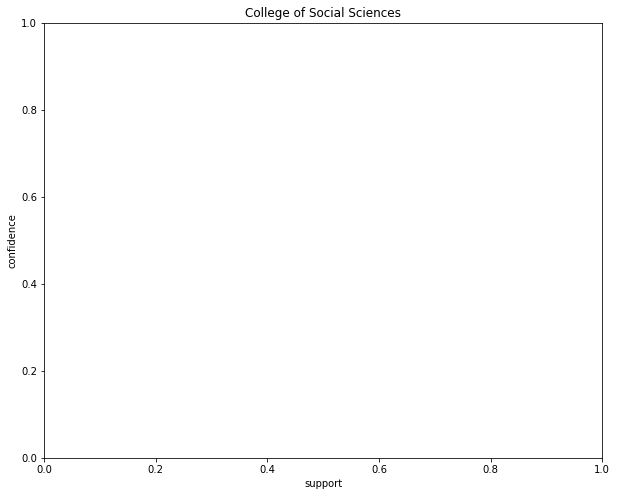

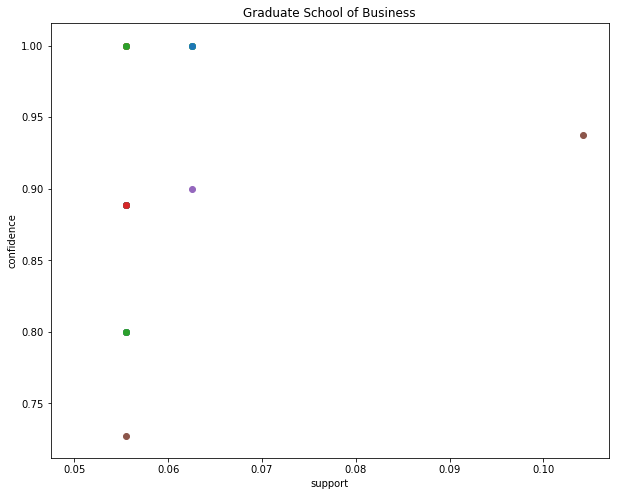

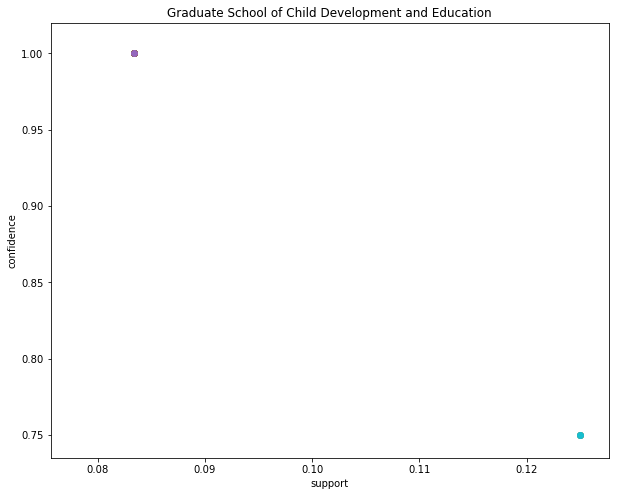

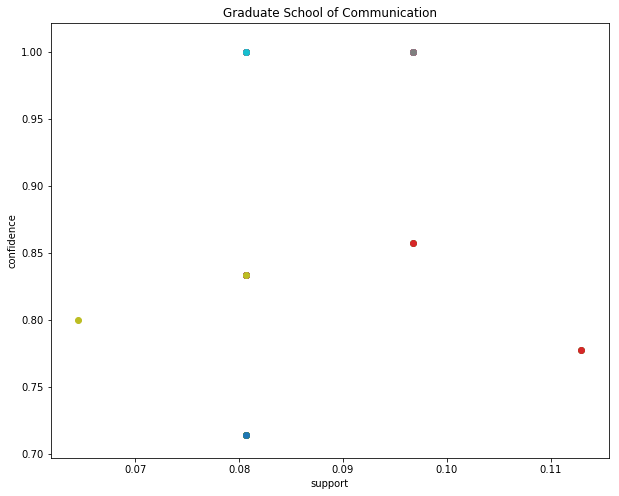

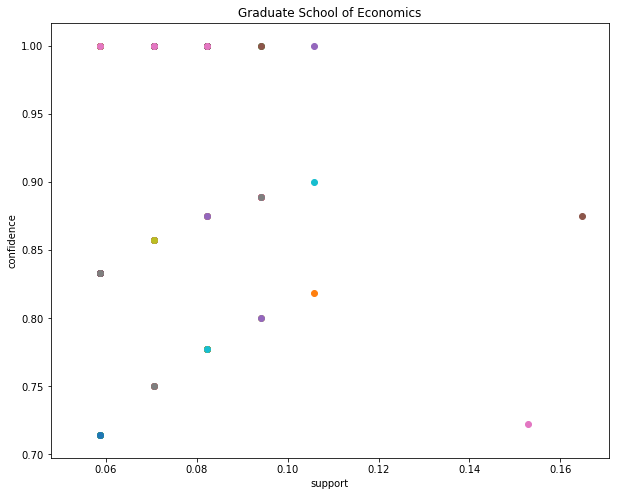

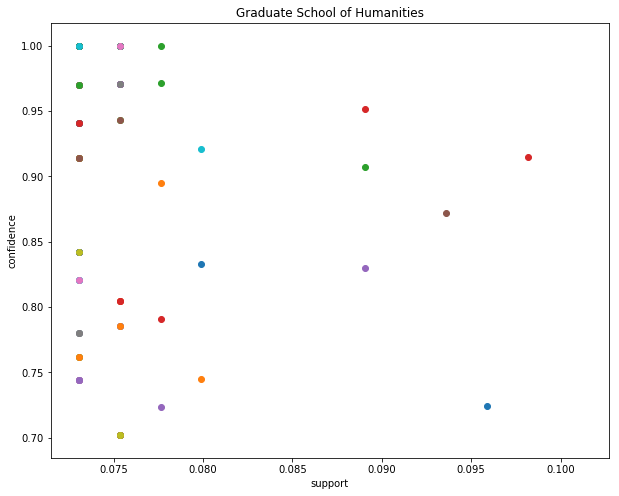

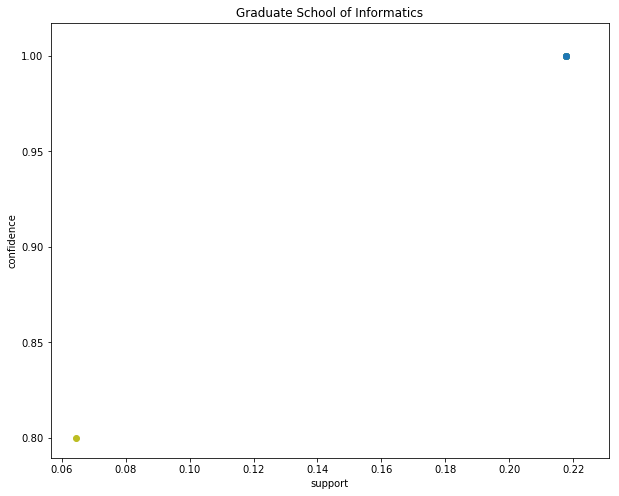

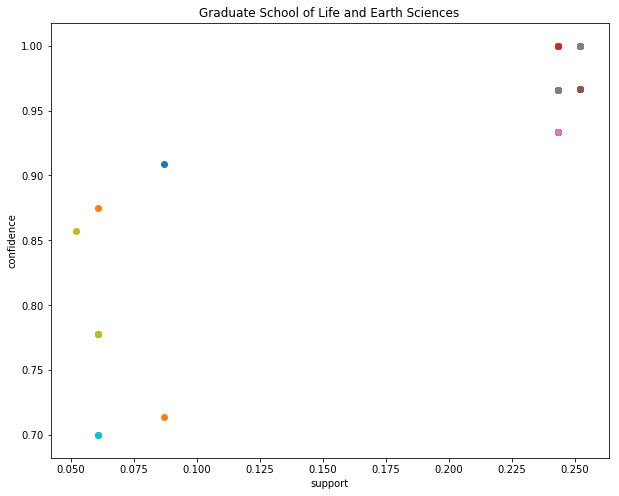

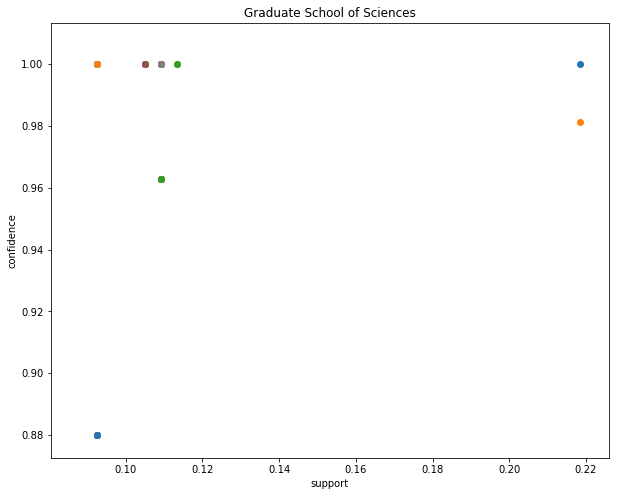

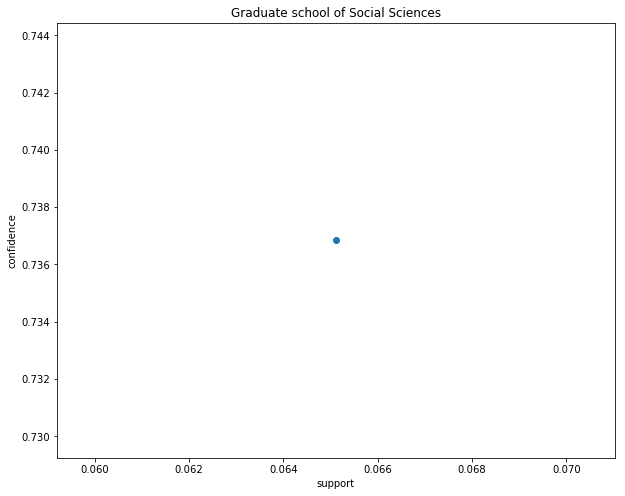

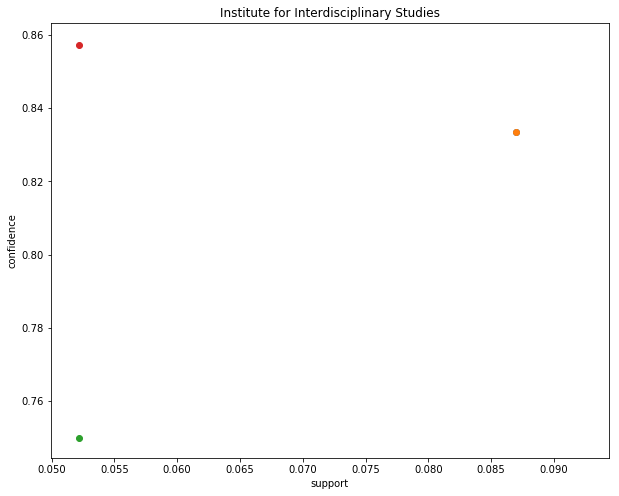

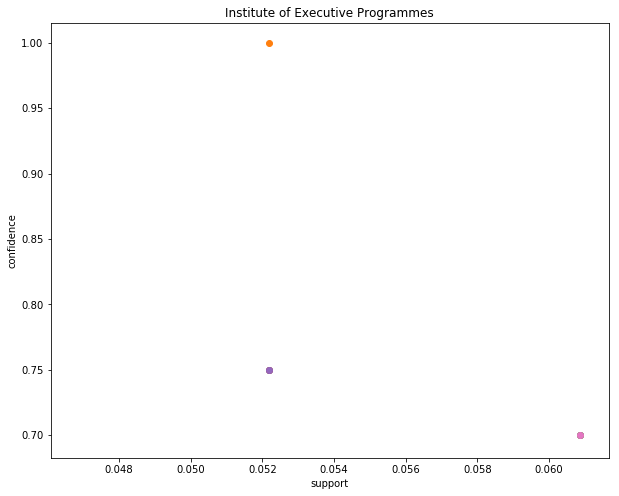

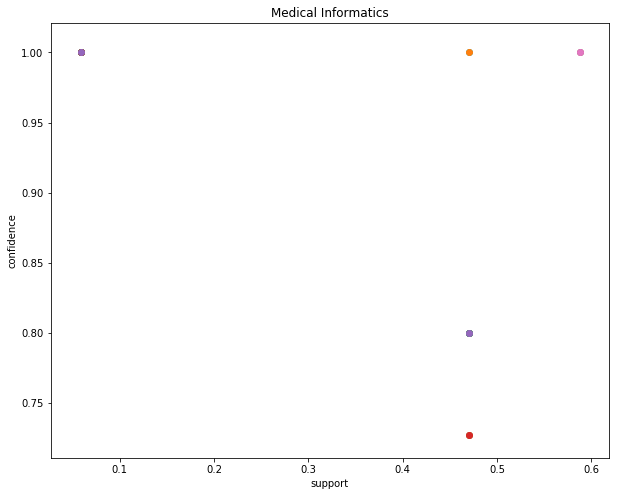

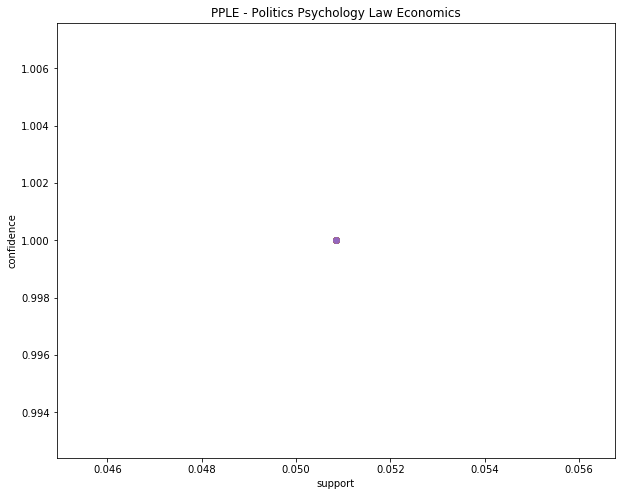

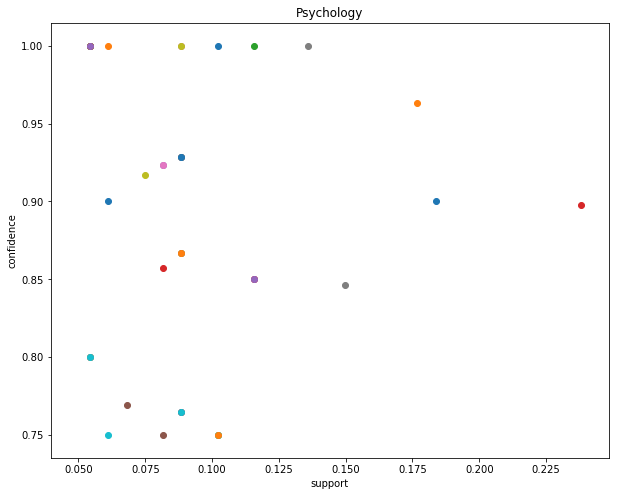

In [48]:
import matplotlib.pyplot as plt

for dept in assoc_rules:
    temp_dict = {}
    cur_dept = assoc_rules[dept]
    for index, row in cur_dept.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        antecedents_str = '-'.join(antecedents)
        consequents_str = '-'.join(consequents)
        support = row['support']
        confidence = row['confidence']
        temp_dict[f'{antecedents_str} -> {consequents_str}'] = [support, confidence]
    #scatter plot of support and confidence
    plt.figure(figsize=(10,8))

    for key, val in temp_dict.items():
        # print(key, val)
        plt.scatter(val[0], val[1], label=key)
    plt.title(dept)
    plt.xlabel('support')
    plt.ylabel('confidence')
    plt.show()